# Notebook Title - Tabular Reinforcement Learning

In this notebook, we will explore Tabular RL methods using Gymnasium Environment.

We create a custom reward grid of size 4 x 4 and run different tabular RL methods.

We will experiment the following methods:

1) SARSA

2) Double Q Learning

3) N-Step SARSA

For SARSA and Double Q Learning, we will also expriment on different hyperparameter configurations namely on discount factor and learning rate and perform Optuna hyperparameter search for these as well. 

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import random

## Defining Grid World Environment

In [ ]:
class GridWorldEnv(gym.Env):
    def __init__(self):
        self.grid_size = 4
        self.states = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        self.actions = ['Up', 'Down', 'Right', 'Left']
        self.rewards = {'-5': -5, '-6': -6, '-1': -1, '+1': 1, '+5': 5, '+20': 20, '0': 0}

        # Define action and state space
        self.action_space = spaces.Discrete(len(self.actions))
        self.state_space = spaces.Discrete(len(self.states))
        self.target_state = (3, 3)

        # Initialize state and position
        self.state = (0, 0)
        self.current_time = 0
        self.max_time = 3*self.grid_size
        # Flatten the state space
        self.state_space_flat = np.arange(len(self.states))

    def flatten_state(self, state):
        return self.state_space_flat[self.states.index(state)]

    def choose_random_action(self, state):
        # Random action selection
        return self.action_space.sample()

    def get_reward(self, state):
        if state == self.target_state:
            reward = self.rewards['+20']
        elif state == (1, 2):
            reward = self.rewards['-6']
        elif state == (2, 2):
            reward = self.rewards['+5']
        elif state == (2, 1):
            reward = self.rewards['-5']
        elif state == (1, 1):
            reward = self.rewards['+1']
        elif state == (1, 0) or state == (0,3):
            reward = self.rewards['-1']
        else:
            reward = self.rewards['0']
        return reward

    def step(self, action):
        self.current_time += 1
        # Update position based on action
        if action == 0:  # Up
            self.state = (max(0, self.state[0] - 1), self.state[1])
        elif action == 1:  # Down
            self.state = (min(self.grid_size - 1, self.state[0] + 1), self.state[1])
        elif action == 2:  # Right
            self.state = (self.state[0], min(self.grid_size - 1, self.state[1] + 1))
        elif action == 3:  # Left
            self.state = (self.state[0], max(0, self.state[1] - 1))

        # Define rewards based on state
        done = False
        reward = self.get_reward(self.state)

        if self.current_time > self.max_time or self.state == self.target_state:
            done = True

        return self.state, reward, done, {}

    def reset(self):
        self.state = (0, 0)
        self.current_time = 0
        return self.state

    def random_walk(self, num_steps=10):
        state = self.reset()
        action = self.choose_random_action(state)
        for step in range(num_steps):
            next_state, reward, done, _ = self.step(action)
            next_action = self.choose_random_action(next_state)
            state = next_state
            action = next_action
            print(f"Step {step+1} Reward {reward}")
            self.render(mode = 'Figure')

    def render(self, mode = "Array"):
        # Visualize the environment
        print(f"Current time: {self.current_time}")
        grid = [[self.get_reward((i,j)) for j in range(self.grid_size)] for i in range(self.grid_size)]
        if mode == "Array":
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    if (i,j) == self.state:
                        print(f'{grid[i][j]} A', end = '\t')
                    elif (i,j) == self.target_state:
                        print(f'{grid[i][j]} T', end = '\t')
                    else:
                        print(grid[i][j], end = '\t')
                print()
            print()
        elif mode == "Figure":
            fig, ax = plt.subplots()
            ax.imshow(grid)

            # Add state rewards as text
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    if (i,j) == self.state:
                        ax.text(j, i, f'{grid[i][j]:.2f} Agent', ha='center', va='center', color='black')
                    elif (i,j) == self.target_state:
                        ax.text(j, i, f'{grid[i][j]:.2f} Target', ha='center', va='center', color='black')
                    else:
                        ax.text(j, i, f'{grid[i][j]:.2f}', ha='center', va='center', color='black')

            plt.show()


Current time: 0


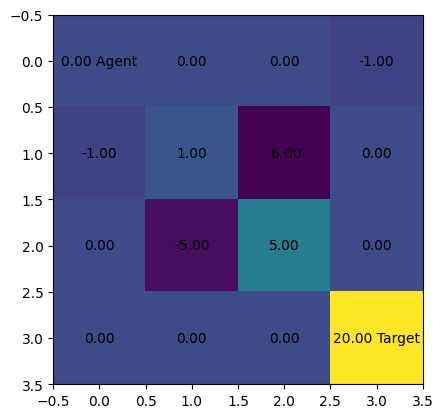

In [ ]:
env = GridWorldEnv()
env.render(mode = 'Figure')

## Grid Random Walk

Step 1 Reward -1
Current time: 1


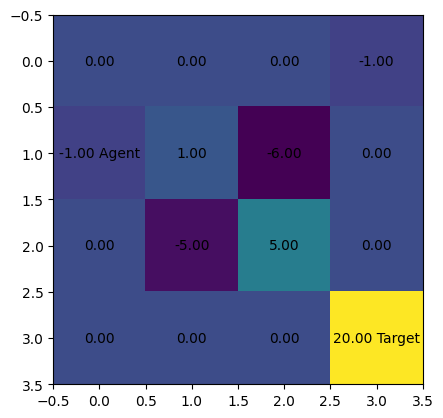

Step 2 Reward 1
Current time: 2


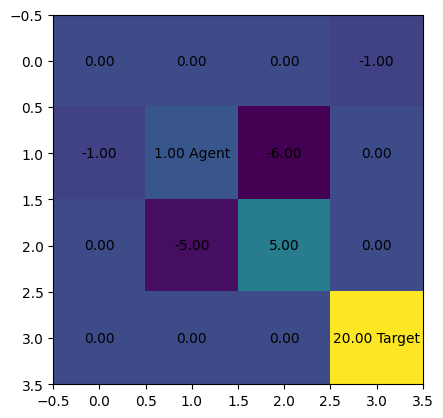

Step 3 Reward -1
Current time: 3


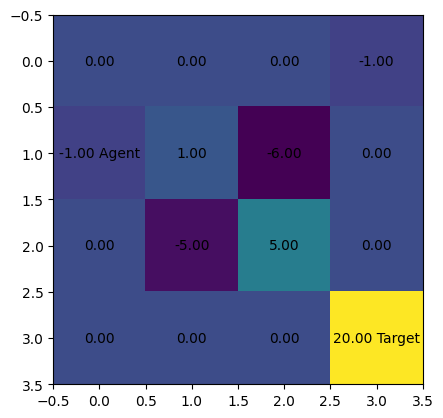

Step 4 Reward 1
Current time: 4


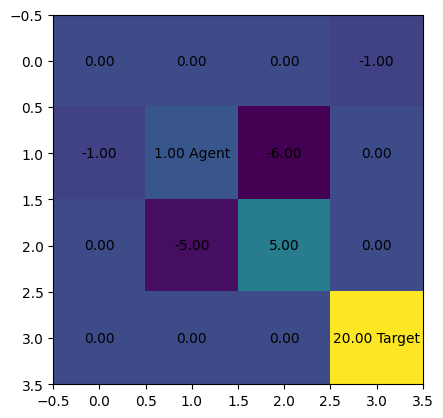

Step 5 Reward 0
Current time: 5


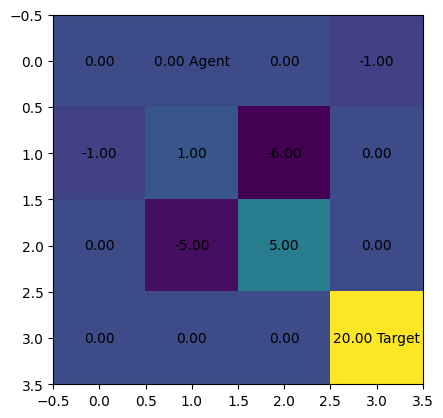

Step 6 Reward 1
Current time: 6


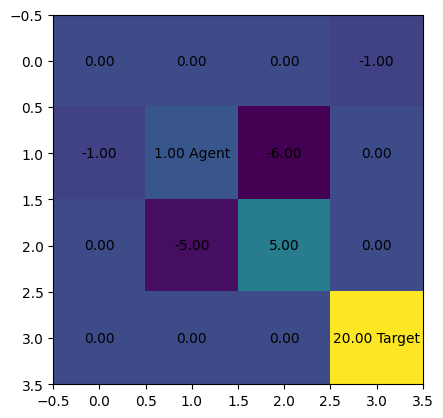

Step 7 Reward -6
Current time: 7


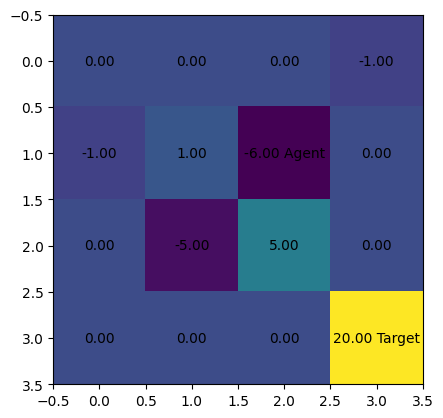

Step 8 Reward 1
Current time: 8


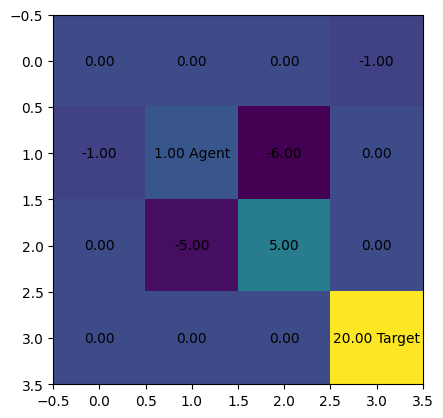

Step 9 Reward -5
Current time: 9


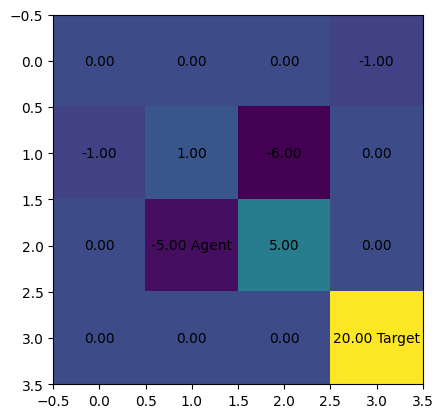

Step 10 Reward 1
Current time: 10


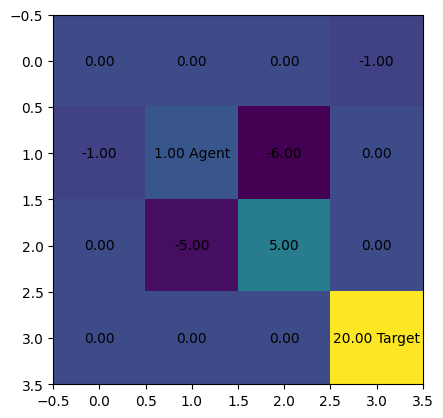

In [ ]:
env.random_walk(num_steps=10)

## State Action Reward State Action (SARSA) Learning

In [ ]:
class AgentSARSA(GridWorldEnv):
    def __init__(self, discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01):
        super().__init__()
        # Q-table initialization
        self.Q_table = np.random.rand(len(self.states), len(self.actions))
        self.Q_table[self.state_space_flat[self.states.index(self.target_state)]] = np.zeros(len(self.actions))

        # SARSA-specific parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Exploration
        else:
            flat_state = self.flatten_state(state)
            return np.argmax(self.Q_table[flat_state, :])  # Exploitation

    def update_q_table(self, state, action, reward, next_state, next_action):
        # SARSA update rule
        flat_state = self.flatten_state(state)
        flat_next_state = self.flatten_state(next_state)

        current_value = self.Q_table[flat_state, action]
        next_value = self.Q_table[flat_next_state, next_action]
        updated_value = current_value + self.learning_rate * (reward + self.discount_factor * next_value - current_value)
        self.Q_table[flat_state, action] = updated_value

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def train(self, num_episodes=1000):
        total_rewards_per_episode = []
        epsilon_values = []

        for episode in range(num_episodes):
            state = self.reset()
            action = self.choose_action(state)
            total_reward = 0

            while True:
                next_state, reward, done, _ = self.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)

                total_reward += reward
                state = next_state
                action = next_action

                if done:
                    break

            total_rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.decay_epsilon()

        return total_rewards_per_episode, epsilon_values

    def evaluate_greedy_policy(self, num_episodes=10):
        total_rewards_per_episode = []

        for episode in range(num_episodes):
            state = self.reset()
            total_reward = 0
            while True:
                action = np.argmax(self.Q_table[self.flatten_state(state), :])  # Greedy action
                next_state, reward, done, _ = self.step(action)

                total_reward += reward
                state = next_state

                if done:
                    break

            total_rewards_per_episode.append(total_reward)

        return total_rewards_per_episode

    def visualize_greedy_policy(self, renderMode = 'Array'):
        state = self.reset()
        total_reward = 0
        self.render(renderMode)
        while True:
            action = np.argmax(self.Q_table[self.flatten_state(state), :])  # Greedy action
            next_state, reward, done, _ = self.step(action)

            total_reward += reward
            state = next_state
            print(f"Step {self.current_time} Reward {reward}")
            self.render(renderMode)
            if done:
                break
        print(f"Total reward: {total_reward}")

In [ ]:
class AgentTrial():
    def __init__(self, agent, type, train_episodes = 1000, greedy_episodes = 100):
        self.agent = agent
        self.type = type
        if type == 'SARSA':
            self.Q_table_init = self.agent.Q_table.copy()
            self.Q_table_final = None
        elif type == 'DoubleQ':
            self.Q1_table_init = self.agent.Q1_table.copy()
            self.Q2_table_init = self.agent.Q2_table.copy()
            self.Q1_table_final = None
            self.Q2_table_final = None
        self.train_episodes = train_episodes
        self.greedy_episodes = greedy_episodes
        self.total_rewards = []
        self.greedy_rewards = []
        self.epsilon_values = []
    def train(self):
        self.total_rewards, self.epsilon_values = self.agent.train(num_episodes=self.train_episodes)
        if self.type == 'SARSA':
            self.Q_table_final = self.agent.Q_table.copy()
        elif self.type == 'DoubleQ':
            self.Q1_table_final = self.agent.Q1_table
            self.Q2_table_final = self.agent.Q2_table
    def print_q_tables(self):
        if self.type == 'SARSA':
            print("Initial Q-Table")
            print(self.Q_table_init)
            print()
            print("Final Q-Table")
            print(self.Q_table_final)
        elif self.type == 'DoubleQ':
            print("Initial Q1-Table")
            print(self.Q1_table_init)
            print("Initial Q2-Table")
            print(self.Q2_table_init)
            print()
            print("Final Q1-Table")
            print(self.Q1_table_final)
            print("Final Q2-Table")
            print(self.Q2_table_final)
    def greedy_eval(self):
        self.greedy_rewards = self.agent.evaluate_greedy_policy(num_episodes=self.greedy_episodes)
    def greedy_walk(self, renderMode = 'Figure'):
        self.agent.visualize_greedy_policy(renderMode = renderMode)
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))

        # Plot total rewards on the first subplot
        ax1.plot(self.total_rewards, label='Training')
        ax1.plot(range(self.train_episodes, self.train_episodes+self.greedy_episodes), self.greedy_rewards, 'ro-', label='Greedy Evaluation')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.set_title('Total Rewards vs Episodes')
        ax1.legend()

        # Plot epsilon values on the second subplot
        ax2.plot(self.epsilon_values)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Epsilon')
        ax2.set_title('Epsilon Values vs Episodes')

        plt.tight_layout()
        plt.show()

Initial Q-Table
[[0.02600252 0.10949807 0.26720609 0.84768899]
 [0.30443776 0.01925658 0.42285481 0.42328391]
 [0.64256722 0.83125556 0.41934362 0.46391278]
 [0.11664524 0.46961709 0.87106524 0.82922893]
 [0.99807763 0.19748226 0.04002985 0.10184948]
 [0.57548819 0.69720765 0.95497756 0.34251479]
 [0.73071168 0.43714818 0.78955291 0.82524094]
 [0.97146699 0.5307746  0.00293255 0.89847426]
 [0.42175714 0.10119136 0.78342141 0.75519159]
 [0.55487419 0.18041575 0.63651784 0.71315967]
 [0.85996045 0.14647373 0.76031463 0.15047178]
 [0.29077521 0.15679345 0.87112507 0.37472354]
 [0.72861948 0.11806735 0.6317796  0.66150933]
 [0.72934045 0.23461334 0.77842823 0.3601968 ]
 [0.38373763 0.77182701 0.47704847 0.52028044]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 5.70368389  6.51515149 11.32465814  8.11977835]
 [ 9.38157386 12.62694958  6.5985693   7.11924052]
 [-0.12798402  2.67185941  1.36451936 10.33993188]
 [ 0.07081424  8.57873356 -0.33808279  0.07386511]
 [ 0.1099086

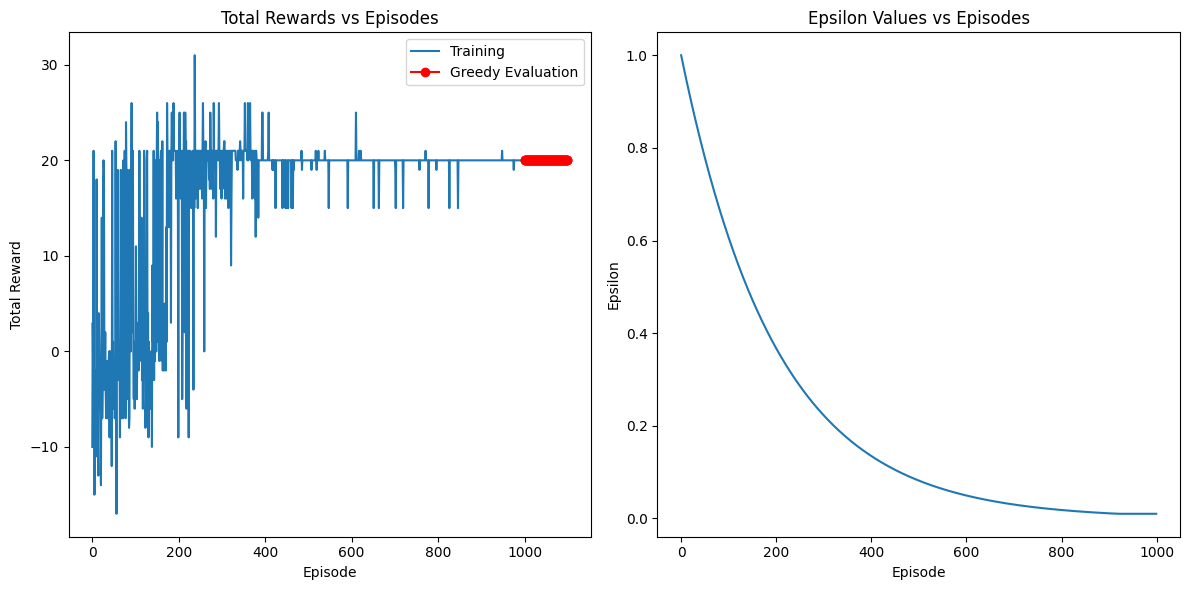

Current time: 0


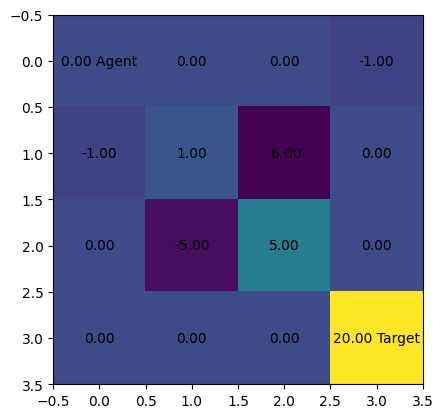

Step 1 Reward 0
Current time: 1


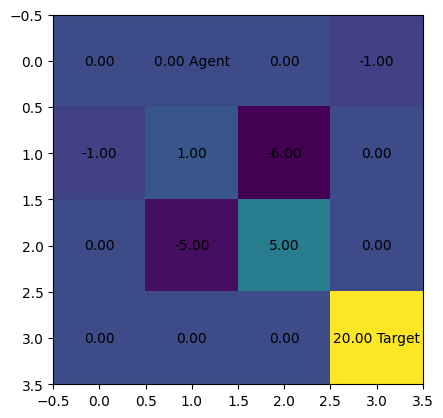

Step 2 Reward 1
Current time: 2


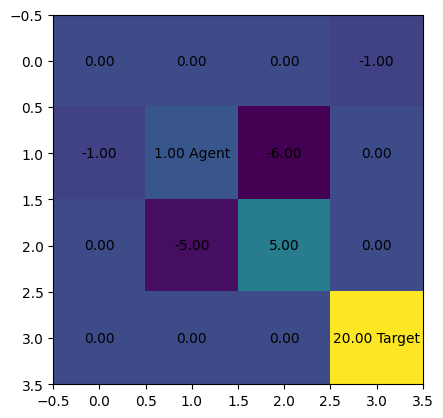

Step 3 Reward -6
Current time: 3


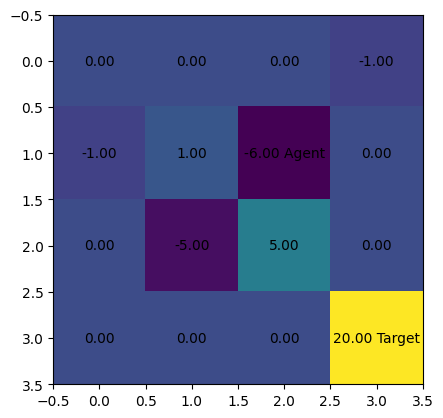

Step 4 Reward 5
Current time: 4


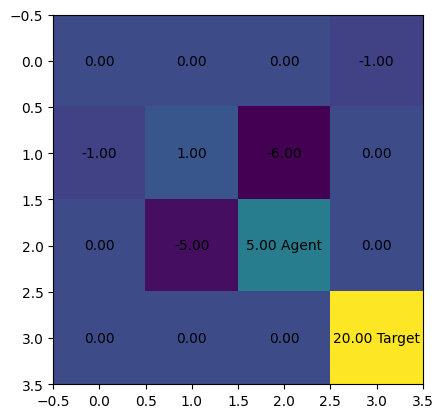

Step 5 Reward 0
Current time: 5


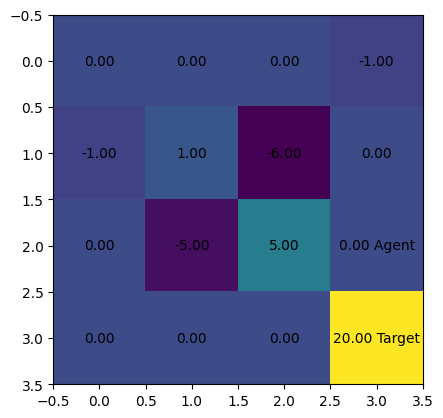

Step 6 Reward 20
Current time: 6


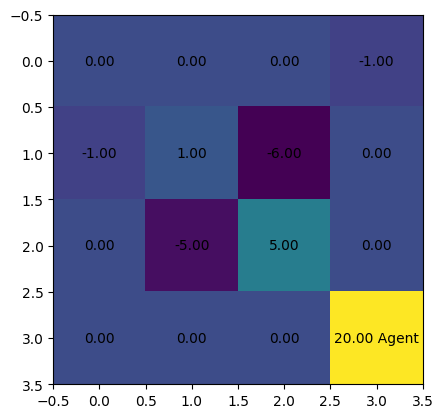

Total reward: 20


In [ ]:
sarsaBase = AgentTrial(AgentSARSA(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaBase.train()

sarsaBase.greedy_eval()

sarsaBase.print_q_tables()

sarsaBase.plot()

sarsaBase.greedy_walk()

## SARSA with experimentation on Discount Factor hyperparameter

Initial Q-Table
[[0.55330369 0.15458314 0.89822275 0.81967624]
 [0.07609606 0.92918028 0.9754463  0.59889719]
 [0.2955617  0.39650247 0.55006203 0.46387439]
 [0.06248941 0.47392244 0.20305758 0.87821665]
 [0.91207481 0.11789681 0.47147786 0.90370486]
 [0.91627512 0.98517246 0.40275559 0.60349731]
 [0.16130345 0.32708674 0.05367826 0.68257088]
 [0.31756616 0.25358588 0.40516333 0.02157465]
 [0.40215391 0.99446627 0.49238724 0.91187488]
 [0.47194232 0.15747704 0.32940279 0.60188346]
 [0.03946281 0.02377652 0.9729255  0.50355536]
 [0.69141898 0.39206448 0.68537437 0.34345965]
 [0.25395525 0.79028968 0.09418942 0.98095848]
 [0.53946046 0.39036766 0.41649798 0.07347074]
 [0.46100421 0.24069264 0.78020671 0.7796988 ]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 1.61750566  0.72504874  3.19309338  1.54142434]
 [ 2.20632923  4.64845443  1.16531397  1.48538267]
 [ 0.39629758 -0.40780995 -0.78329609  2.47374215]
 [-0.27913942  0.32996111 -0.20656393  0.25683803]
 [-0.0374364

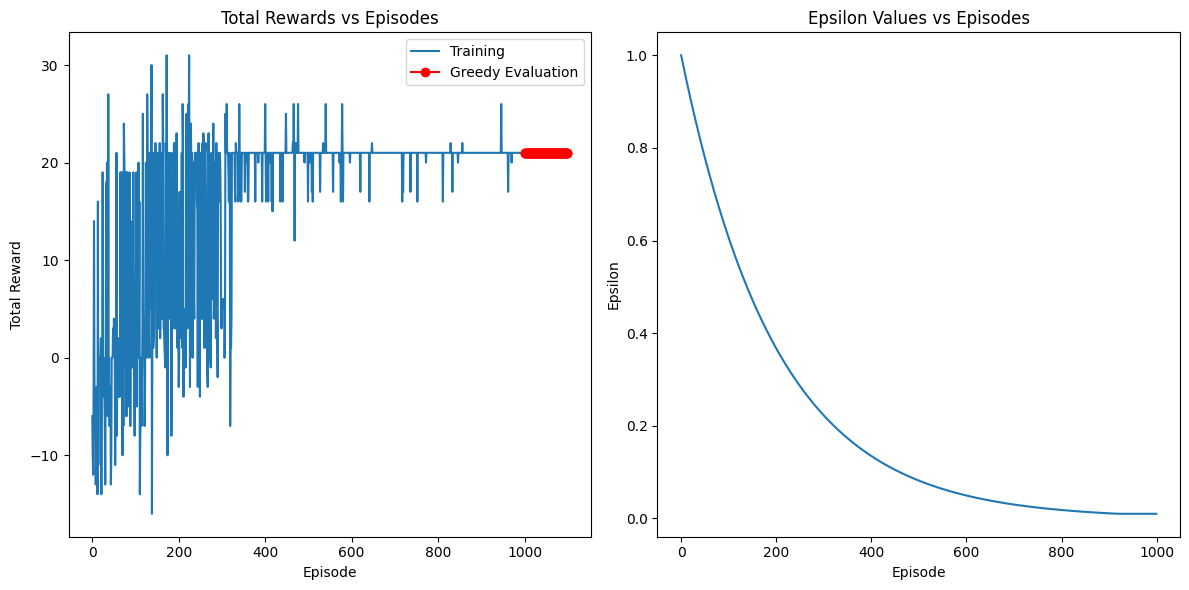

Current time: 0


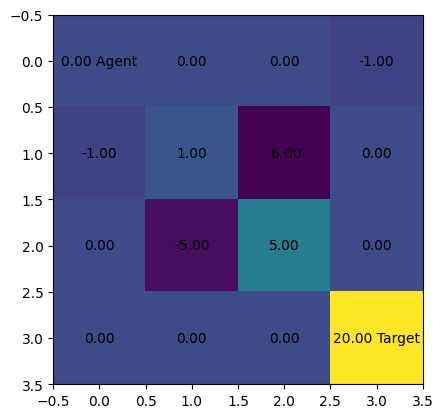

Step 1 Reward 0
Current time: 1


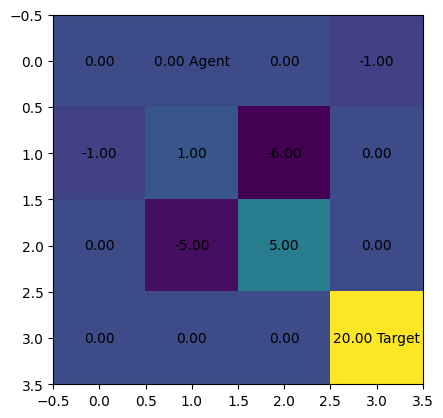

Step 2 Reward 1
Current time: 2


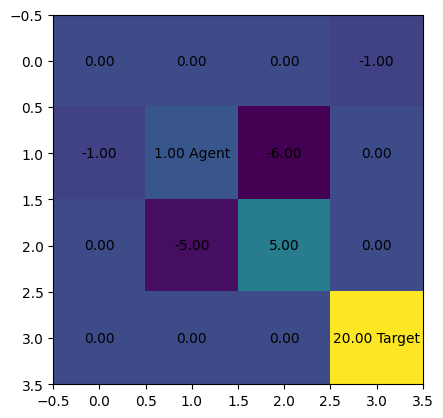

Step 3 Reward -5
Current time: 3


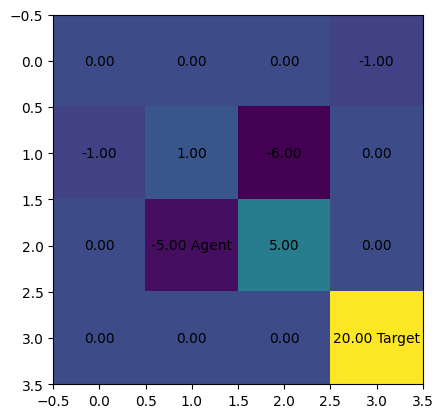

Step 4 Reward 5
Current time: 4


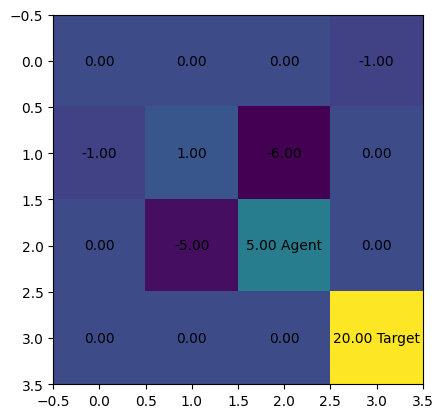

Step 5 Reward 0
Current time: 5


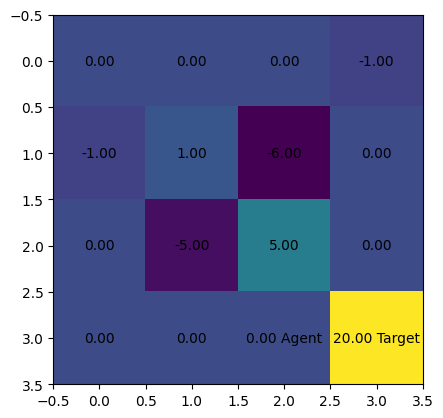

Step 6 Reward 20
Current time: 6


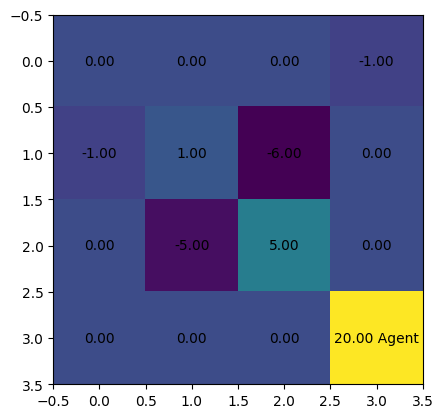

Total reward: 21


In [ ]:
sarsaDiscount1 = AgentTrial(AgentSARSA(discount_factor = 0.7, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaDiscount1.train()

sarsaDiscount1.greedy_eval()

sarsaDiscount1.print_q_tables()

sarsaDiscount1.plot()

sarsaDiscount1.greedy_walk()

Initial Q-Table
[[0.41071346 0.13956818 0.53799253 0.55380153]
 [0.15151714 0.87636052 0.09328194 0.82105379]
 [0.47868033 0.2372289  0.72225787 0.71967721]
 [0.23961012 0.27023729 0.01575376 0.45039868]
 [0.89672105 0.94449501 0.45419379 0.40501325]
 [0.68749472 0.65531832 0.20231082 0.81542854]
 [0.52562299 0.08728    0.57909856 0.28101379]
 [0.90182876 0.03475313 0.02727079 0.06529061]
 [0.7694693  0.90604816 0.45439538 0.20131275]
 [0.13985515 0.06511981 0.01907107 0.91249274]
 [0.70498808 0.91663612 0.73255187 0.24773478]
 [0.68897414 0.12757883 0.29949358 0.60348049]
 [0.46754647 0.37046132 0.08038402 0.22440322]
 [0.01954332 0.83608053 0.63377321 0.00951598]
 [0.92746332 0.59948799 0.09893513 0.79405844]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 0.13224803 -0.5961088   0.46939411  0.14080884]
 [ 0.45256401  1.18828708  0.15985821  0.16772707]
 [-0.2105022  -3.79535983 -0.95715532  0.46539379]
 [-0.57392818  0.67932913 -0.58123343  0.02855732]
 [-0.0292390

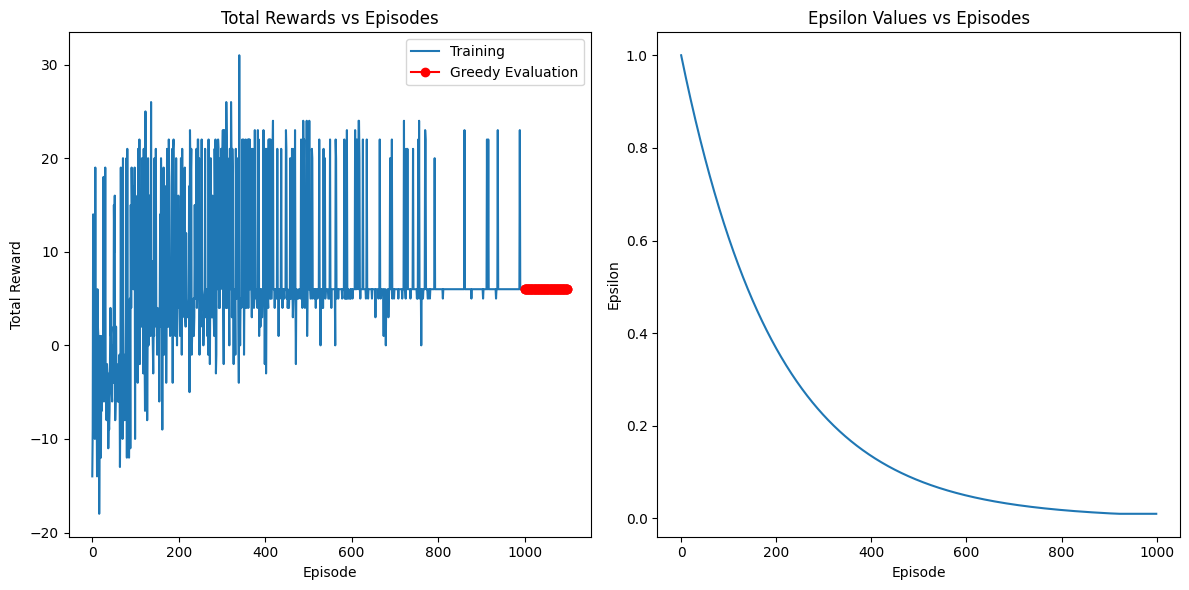

Current time: 0


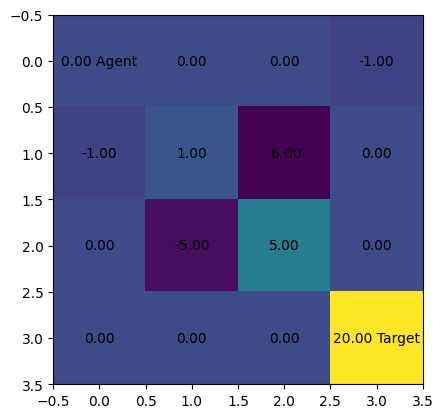

Step 1 Reward 0
Current time: 1


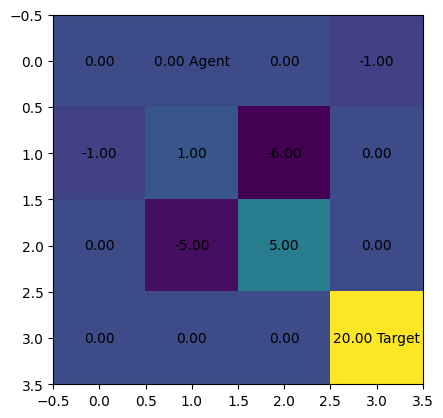

Step 2 Reward 1
Current time: 2


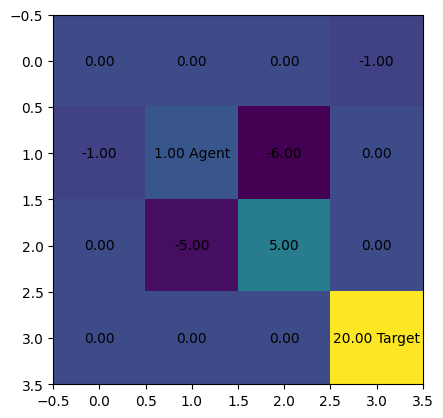

Step 3 Reward 0
Current time: 3


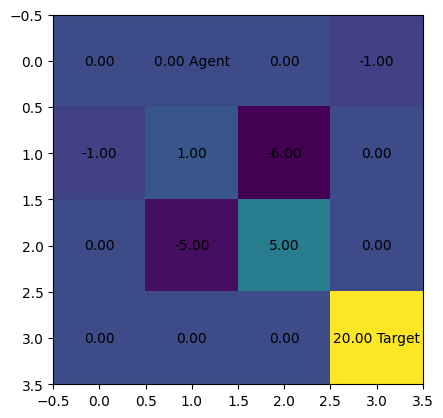

Step 4 Reward 1
Current time: 4


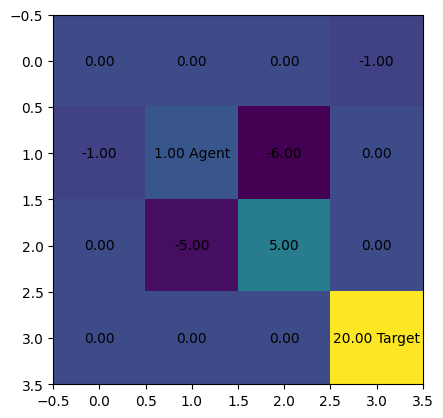

Step 5 Reward 0
Current time: 5


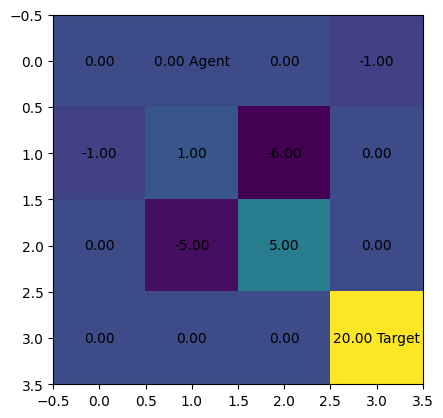

Step 6 Reward 1
Current time: 6


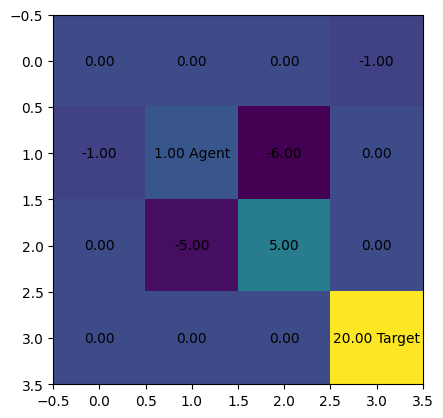

Step 7 Reward 0
Current time: 7


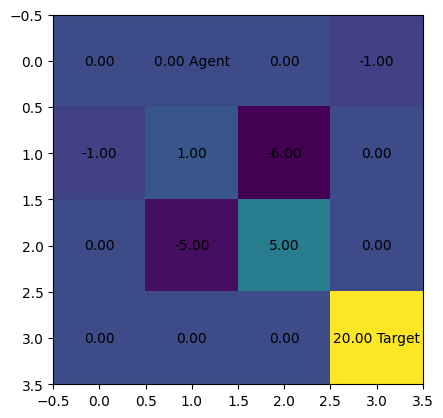

Step 8 Reward 1
Current time: 8


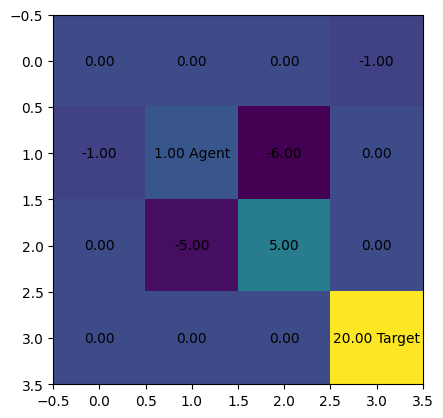

Step 9 Reward 0
Current time: 9


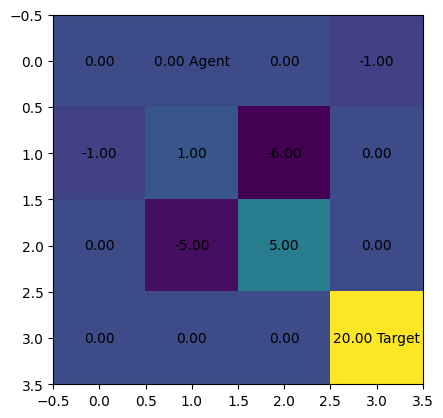

Step 10 Reward 1
Current time: 10


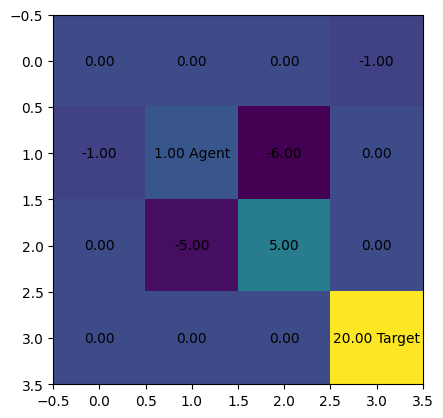

Step 11 Reward 0
Current time: 11


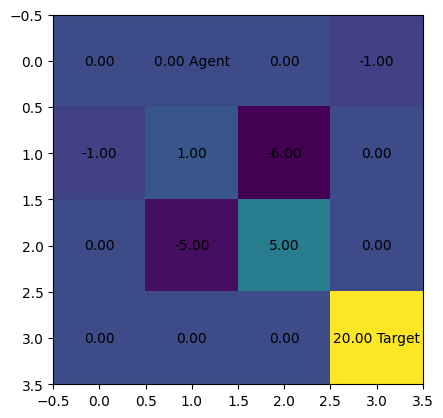

Step 12 Reward 1
Current time: 12


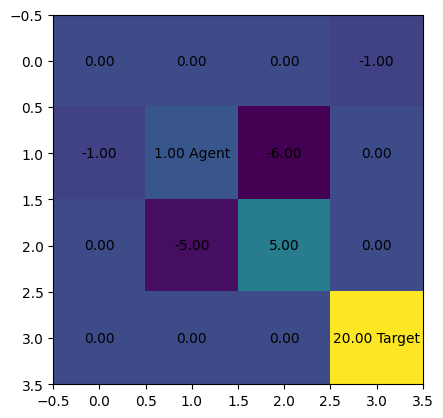

Step 13 Reward 0
Current time: 13


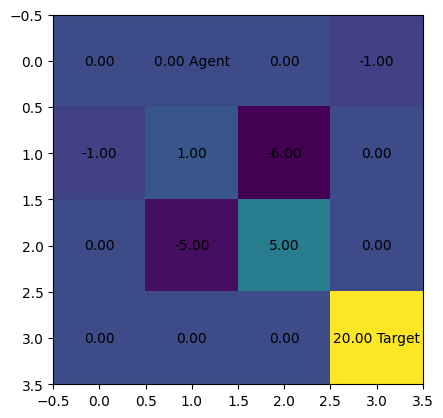

Total reward: 6


In [ ]:
sarsaDiscount2 = AgentTrial(AgentSARSA(discount_factor = 0.4, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaDiscount2.train()

sarsaDiscount2.greedy_eval()

sarsaDiscount2.print_q_tables()

sarsaDiscount2.plot()

sarsaDiscount2.greedy_walk()

Initial Q-Table
[[0.93580831 0.52133664 0.35274631 0.97979304]
 [0.72230534 0.49566738 0.4636587  0.10383004]
 [0.71352749 0.06208026 0.60284648 0.66774761]
 [0.95598161 0.58130975 0.11467073 0.55503573]
 [0.12261872 0.11761496 0.11480692 0.65073266]
 [0.20625191 0.53472511 0.63775339 0.40589333]
 [0.76060527 0.33168384 0.59170406 0.75399794]
 [0.39007232 0.20454854 0.44554859 0.16626147]
 [0.83793441 0.60639654 0.55447817 0.05885494]
 [0.07826286 0.78004169 0.62691981 0.44815176]
 [0.52410874 0.32595535 0.33889493 0.05542   ]
 [0.7454203  0.61287395 0.22639353 0.17708812]
 [0.7249221  0.71449677 0.90680686 0.38278417]
 [0.90933983 0.89696938 0.32175253 0.54851477]
 [0.34323274 0.37595808 0.96682188 0.89922877]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 6.50941022e+01  7.77247440e+00  1.42644408e+02  4.81273425e+01]
 [ 2.01603556e+01  1.43539766e+02  1.91263626e+01  4.51717637e+01]
 [ 1.27476660e+00 -6.67765369e-01 -6.83776551e-01  5.25633015e+01]
 [-4.57154303e-

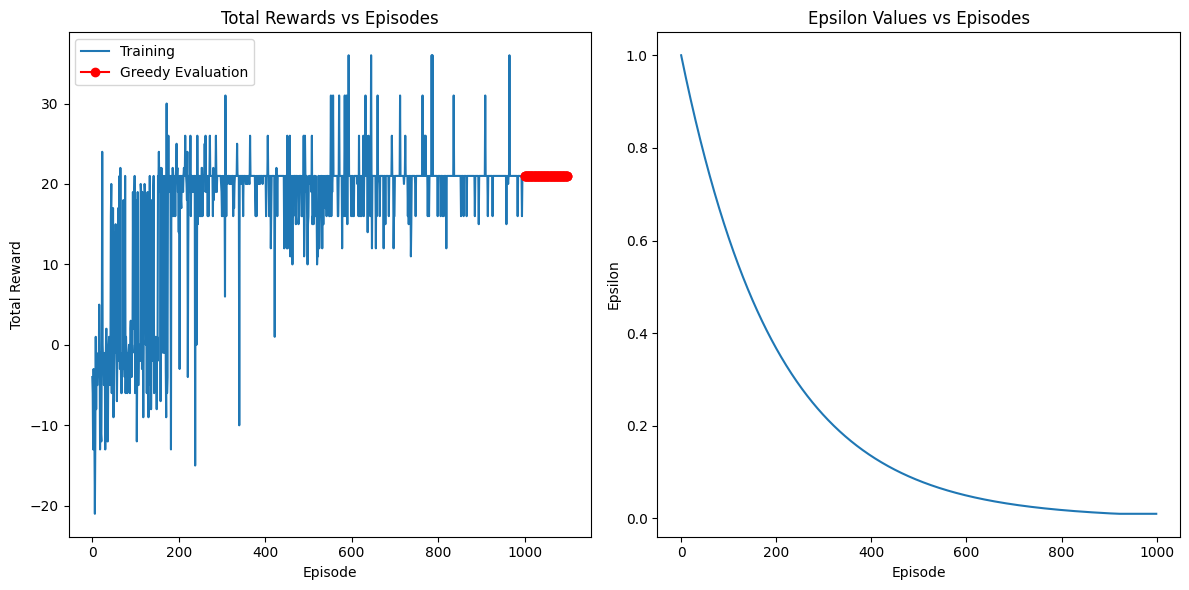

Current time: 0


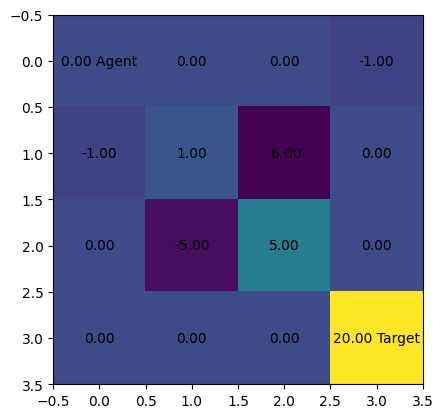

Step 1 Reward 0
Current time: 1


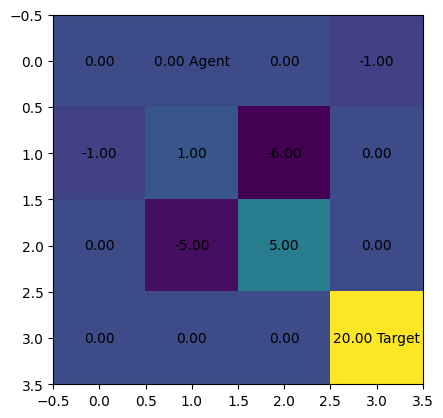

Step 2 Reward 1
Current time: 2


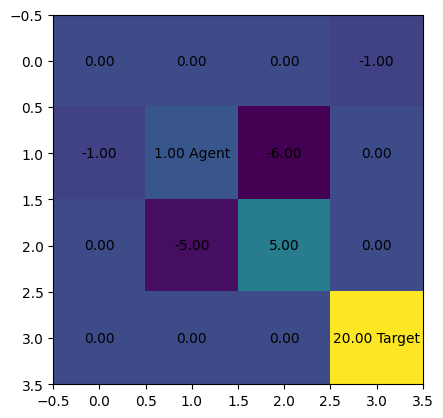

Step 3 Reward -5
Current time: 3


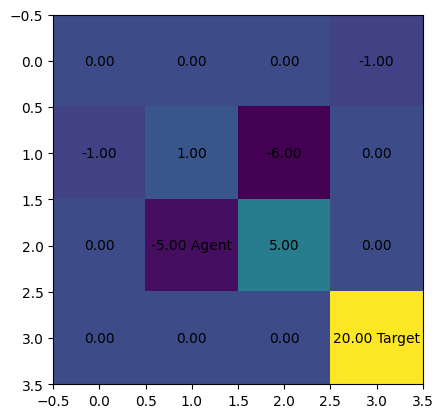

Step 4 Reward 5
Current time: 4


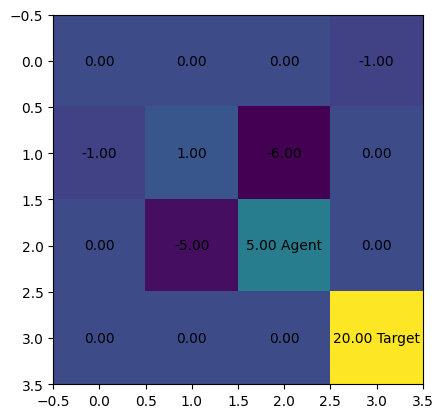

Step 5 Reward 0
Current time: 5


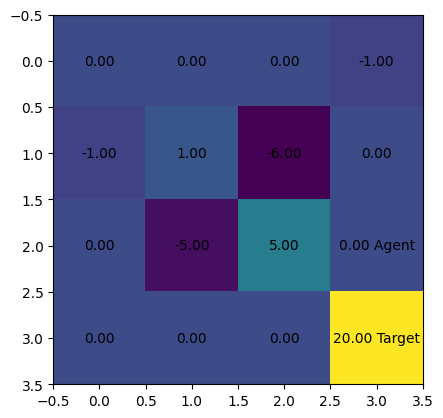

Step 6 Reward 5
Current time: 6


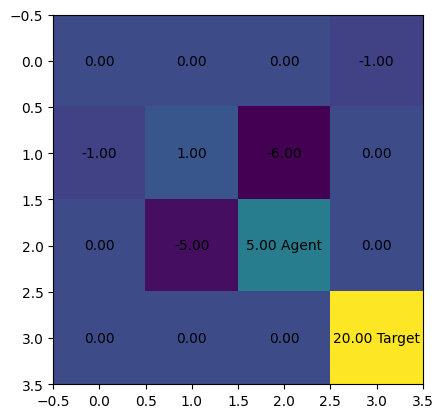

Step 7 Reward 0
Current time: 7


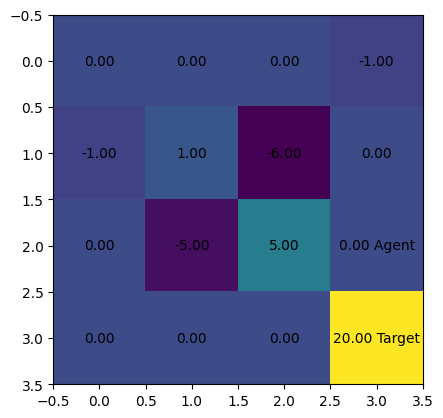

Step 8 Reward 5
Current time: 8


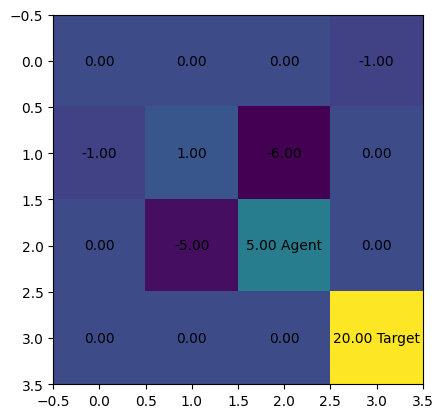

Step 9 Reward 0
Current time: 9


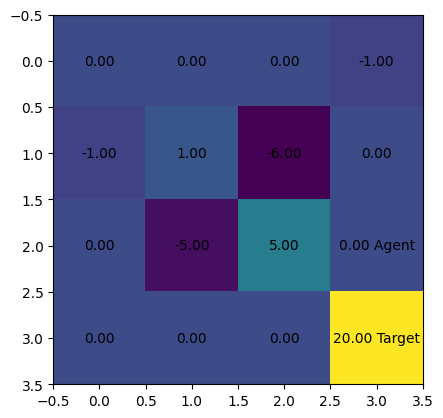

Step 10 Reward 5
Current time: 10


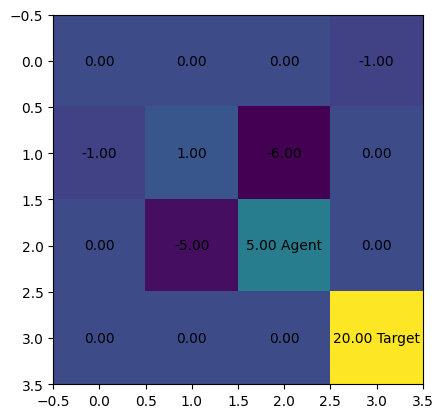

Step 11 Reward 0
Current time: 11


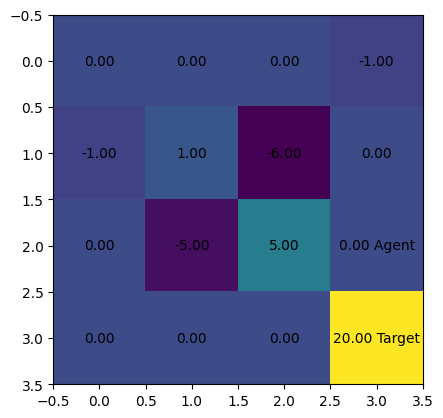

Step 12 Reward 5
Current time: 12


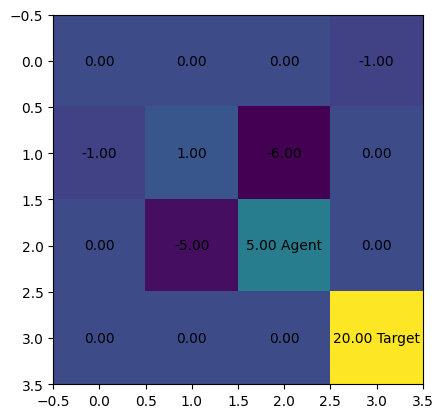

Step 13 Reward 0
Current time: 13


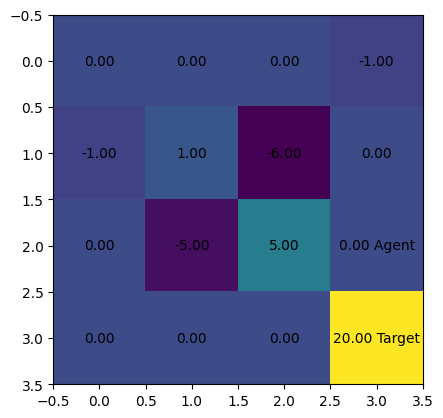

Total reward: 21


In [ ]:
sarsaDiscount3 = AgentTrial(AgentSARSA(discount_factor = 0.99, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaDiscount3.train()

sarsaDiscount3.greedy_eval()

sarsaDiscount3.print_q_tables()

sarsaDiscount3.plot()

sarsaDiscount3.greedy_walk()

## SARSA with experimentation on Learning Rate Hyperparameter

Initial Q-Table
[[0.85192515 0.4326278  0.09059729 0.84957828]
 [0.71972673 0.79062824 0.40010982 0.6638169 ]
 [0.76785188 0.00143672 0.11177113 0.79268873]
 [0.48157731 0.02687808 0.74710182 0.06726065]
 [0.12598396 0.17376577 0.08530059 0.75594741]
 [0.2178431  0.53639442 0.38366629 0.93835499]
 [0.33444109 0.71282426 0.67782264 0.36831899]
 [0.75897321 0.52459604 0.28231173 0.56010256]
 [0.9980071  0.14783104 0.10821402 0.34016687]
 [0.44942233 0.27555564 0.03006884 0.54712816]
 [0.11159844 0.00602625 0.61618079 0.32151014]
 [0.81181118 0.3892636  0.48795109 0.26051424]
 [0.77327663 0.24152666 0.65635609 0.28062295]
 [0.79245287 0.44651771 0.47712959 0.22765207]
 [0.19192741 0.12840744 0.10476655 0.99304608]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 8.49665237 14.02941552  9.00123715  9.30422643]
 [ 9.04898265  7.64458314 10.88575175  7.6327394 ]
 [ 8.42727275 11.05818557 12.37882673  6.41677625]
 [12.0572072  16.02203226 11.17106456  8.55968883]
 [ 6.6962666

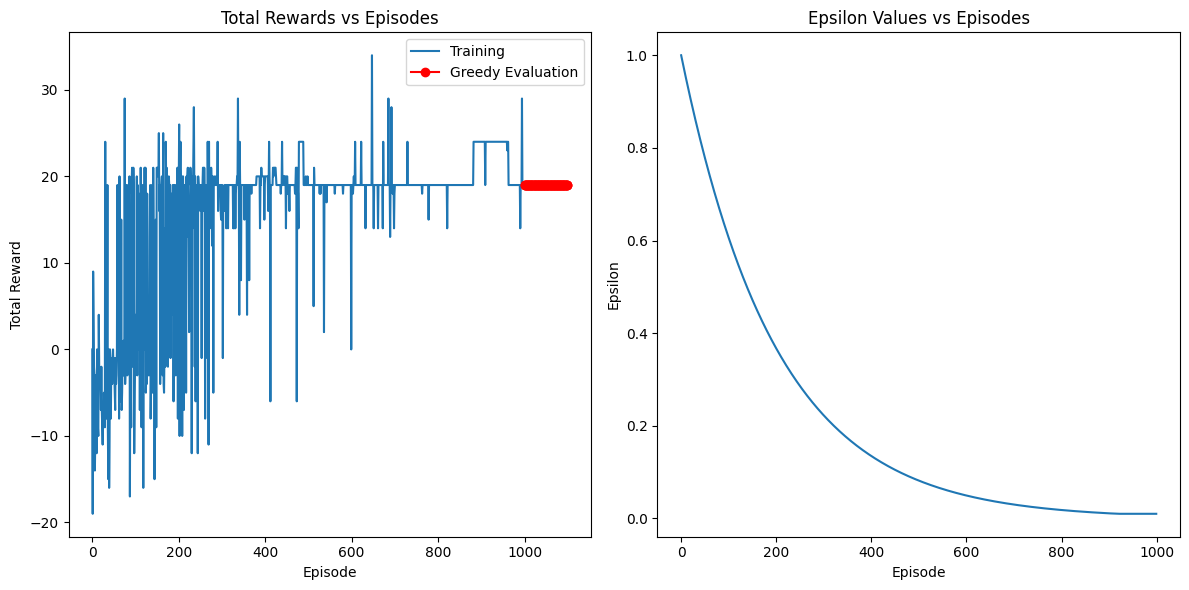

Current time: 0


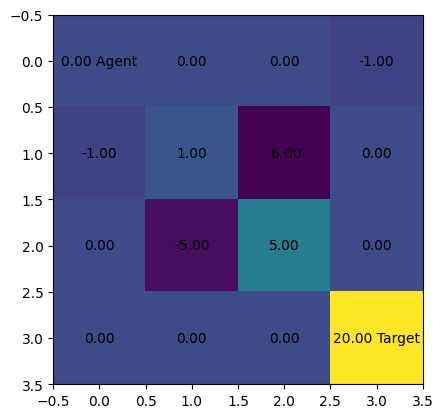

Step 1 Reward -1
Current time: 1


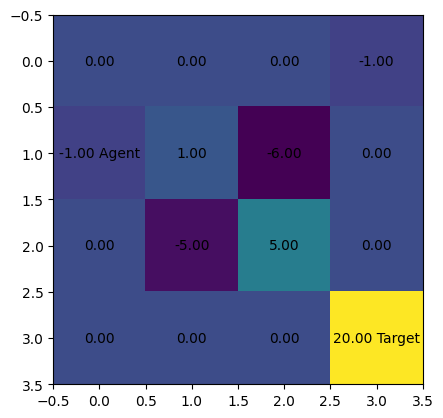

Step 2 Reward 0
Current time: 2


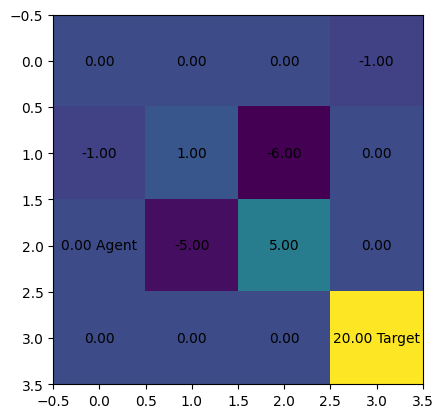

Step 3 Reward 0
Current time: 3


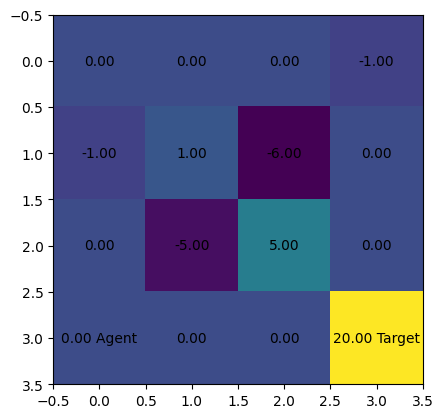

Step 4 Reward 0
Current time: 4


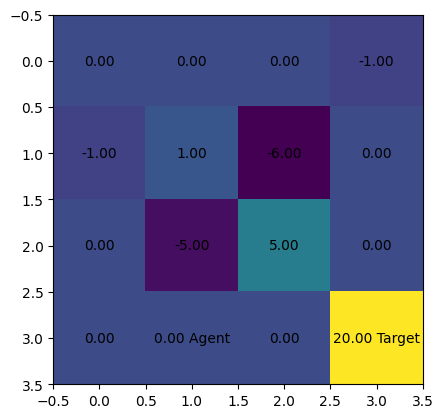

Step 5 Reward 0
Current time: 5


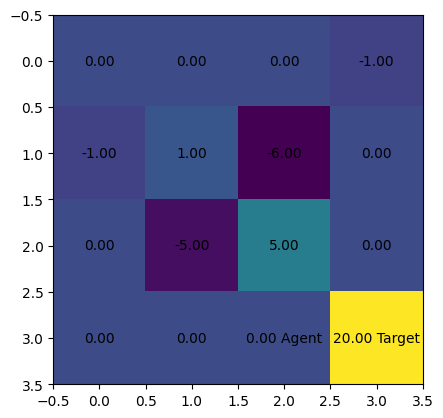

Step 6 Reward 5
Current time: 6


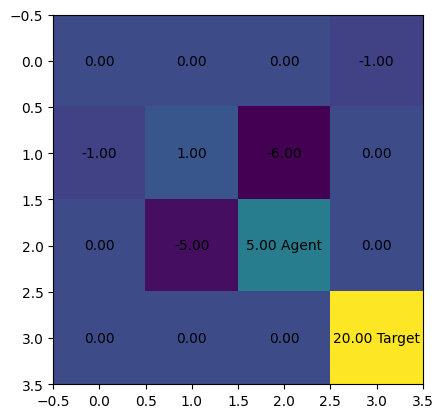

Step 7 Reward 0
Current time: 7


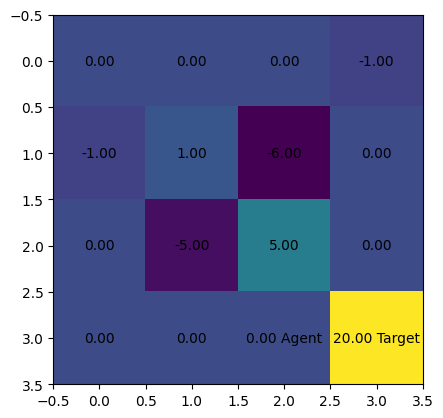

Step 8 Reward 5
Current time: 8


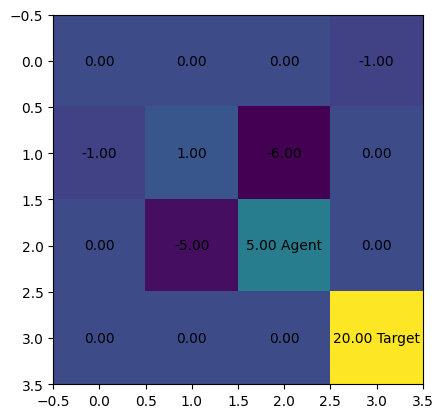

Step 9 Reward 0
Current time: 9


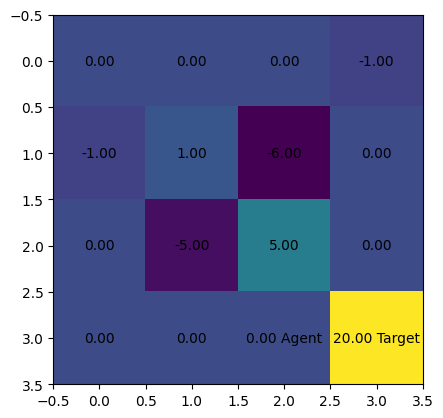

Step 10 Reward 5
Current time: 10


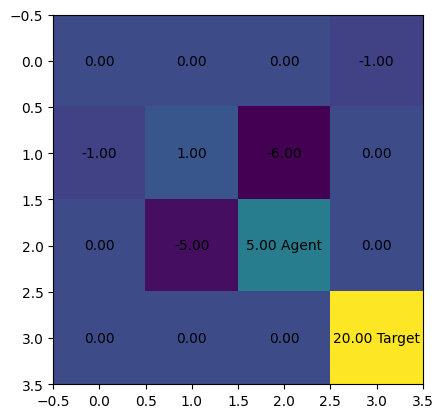

Step 11 Reward 0
Current time: 11


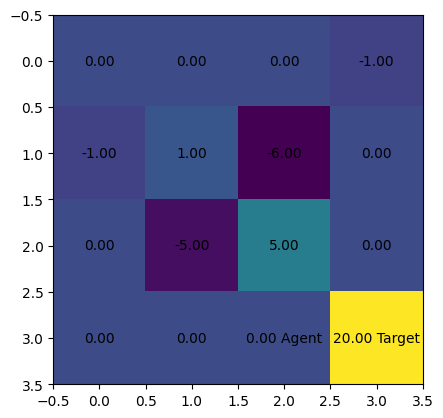

Step 12 Reward 5
Current time: 12


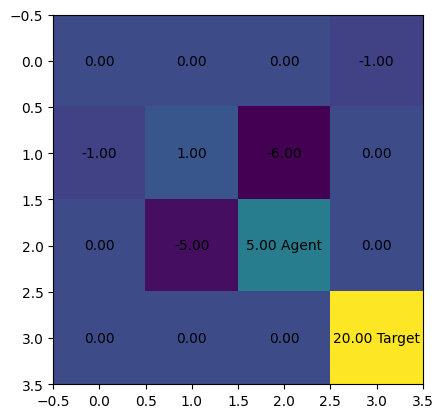

Step 13 Reward 0
Current time: 13


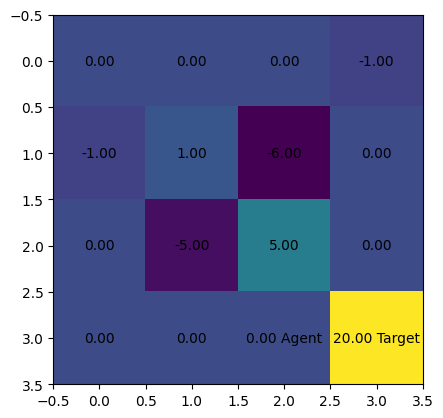

Total reward: 19


In [ ]:
sarsaLR1 = AgentTrial(AgentSARSA(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.5, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaLR1.train()

sarsaLR1.greedy_eval()

sarsaLR1.print_q_tables()

sarsaLR1.plot()

sarsaLR1.greedy_walk()

Initial Q-Table
[[0.12513631 0.47872191 0.04090115 0.88427332]
 [0.17053494 0.55064522 0.90259279 0.23914638]
 [0.71452459 0.82427917 0.32794809 0.60422997]
 [0.81360686 0.32085943 0.83259562 0.92902043]
 [0.04652913 0.53570957 0.40595684 0.40587267]
 [0.53353462 0.88414853 0.89810339 0.41301095]
 [0.07129034 0.56207565 0.80879263 0.91436257]
 [0.55567553 0.33082274 0.97803859 0.60062904]
 [0.55180015 0.07126551 0.42837918 0.58635425]
 [0.5143021  0.00831418 0.7369396  0.21264523]
 [0.08303572 0.29241616 0.73118006 0.27113884]
 [0.85138558 0.32786168 0.40593997 0.41179957]
 [0.00226952 0.52109863 0.46169569 0.4298917 ]
 [0.27167447 0.90747438 0.26242798 0.80858712]
 [0.25653568 0.55488506 0.78355364 0.92489637]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 7.0448951   4.4493079  10.99959451  5.29240061]
 [ 6.83174668  5.11108242 12.222       7.78088534]
 [ 6.81451567  3.93512537 13.58        6.9299167 ]
 [10.70850496 16.2        12.05482618  8.41649797]
 [ 9.2889712

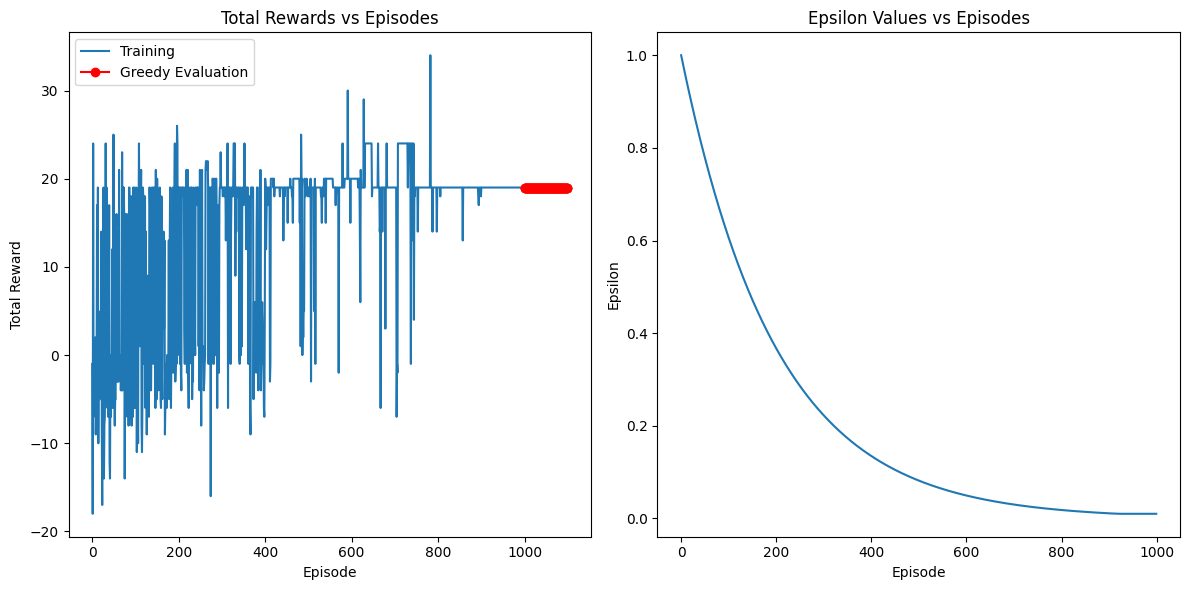

Current time: 0


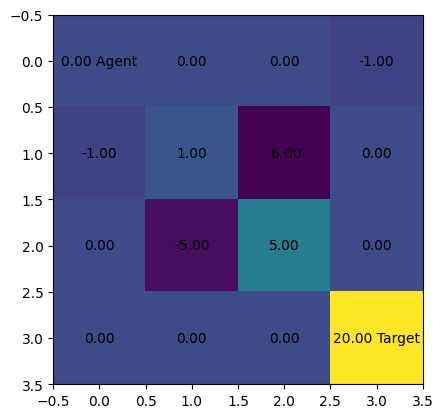

Step 1 Reward 0
Current time: 1


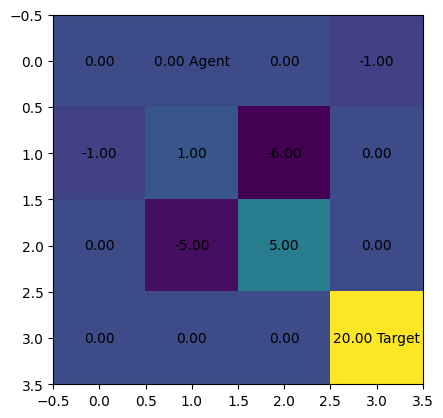

Step 2 Reward 0
Current time: 2


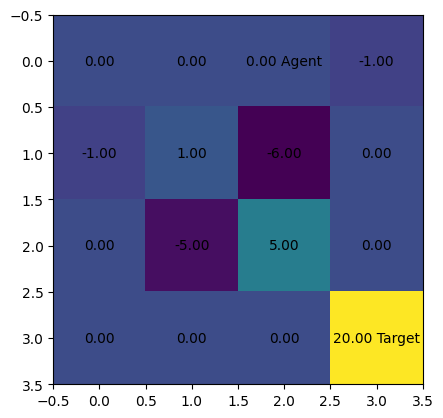

Step 3 Reward -1
Current time: 3


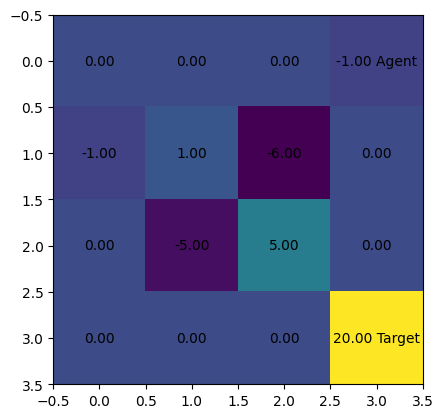

Step 4 Reward 0
Current time: 4


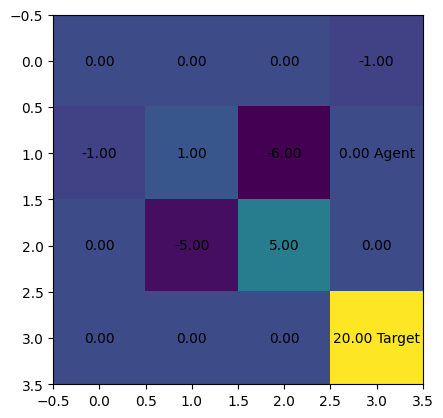

Step 5 Reward 0
Current time: 5


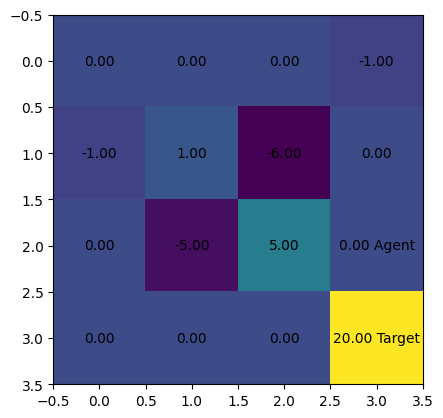

Step 6 Reward 20
Current time: 6


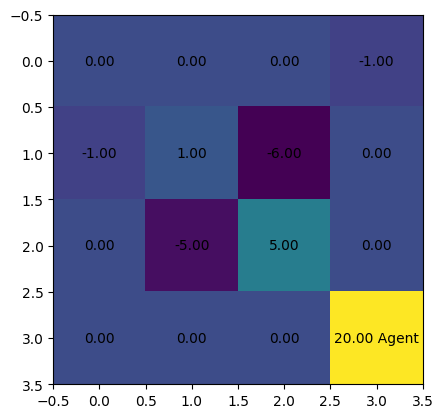

Total reward: 19


In [ ]:
sarsaLR2 = AgentTrial(AgentSARSA(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.75, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaLR2.train()

sarsaLR2.greedy_eval()

sarsaLR2.print_q_tables()

sarsaLR2.plot()

sarsaLR2.greedy_walk()

Initial Q-Table
[[0.52784598 0.30721031 0.71365573 0.13870761]
 [0.5242137  0.21137891 0.37763061 0.72609602]
 [0.13579659 0.28126726 0.48570505 0.12251882]
 [0.58259372 0.8155709  0.3753429  0.5906821 ]
 [0.15927767 0.3607951  0.33624246 0.17321249]
 [0.80514645 0.21451231 0.37263861 0.66979056]
 [0.32350934 0.9136707  0.48334634 0.71358882]
 [0.39713229 0.52295472 0.53234511 0.03661854]
 [0.34036905 0.67823879 0.49979808 0.95178823]
 [0.46572662 0.74381503 0.44367461 0.80897504]
 [0.1891649  0.94354804 0.93075004 0.64922539]
 [0.75469322 0.61782625 0.19357939 0.82631656]
 [0.31519782 0.17670104 0.65906775 0.02281607]
 [0.09835804 0.71510897 0.1339543  0.78826962]
 [0.54137241 0.32988139 0.25843048 0.76021307]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 2.38566292e+00  8.36049340e-01  1.19519272e+01  2.89059444e+00]
 [ 3.63944549e+00  1.33387866e+01  8.69828293e-01  1.20579383e+00]
 [-1.91058369e-01 -2.14194342e+00 -2.48740972e-01  3.82574433e+00]
 [ 8.37691309e-

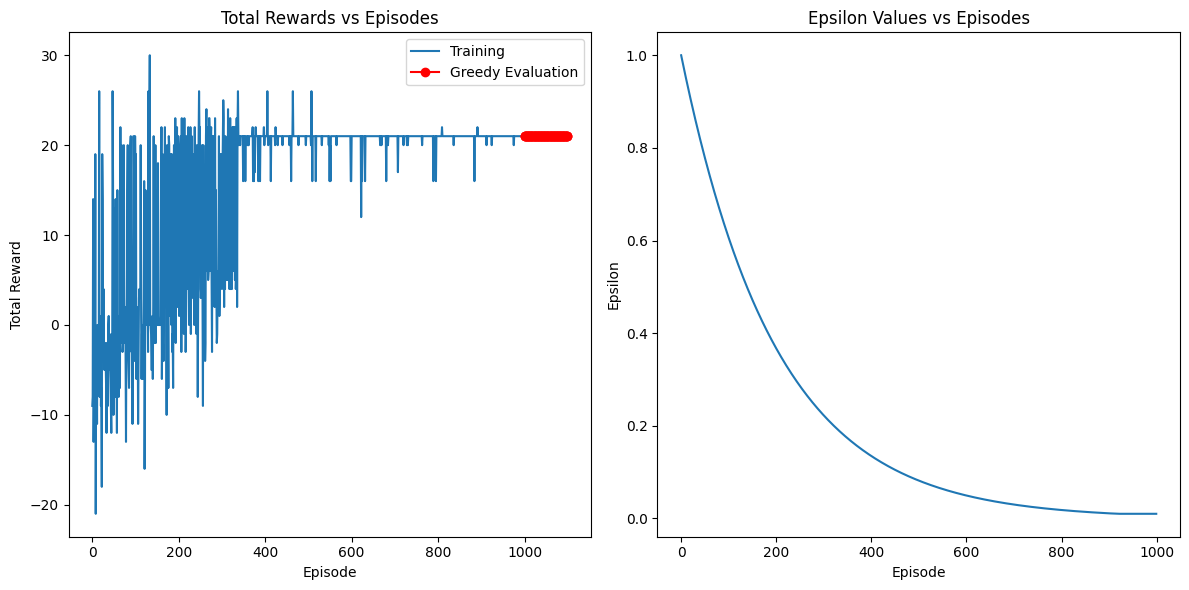

Current time: 0


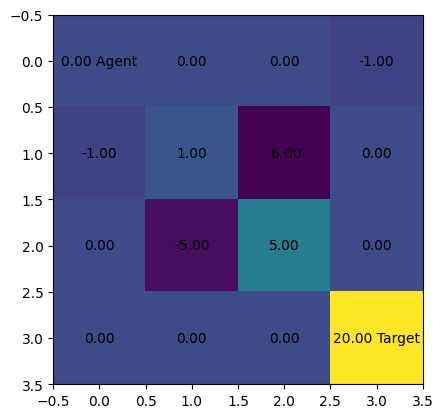

Step 1 Reward 0
Current time: 1


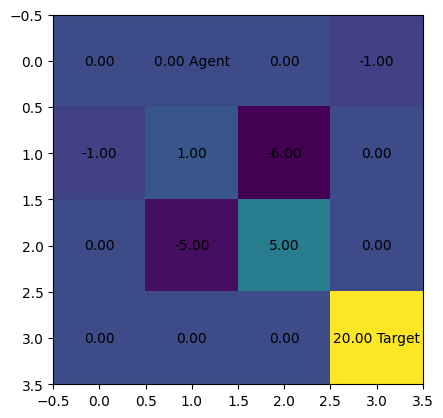

Step 2 Reward 1
Current time: 2


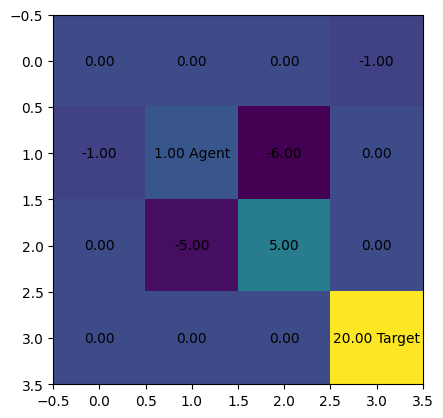

Step 3 Reward -5
Current time: 3


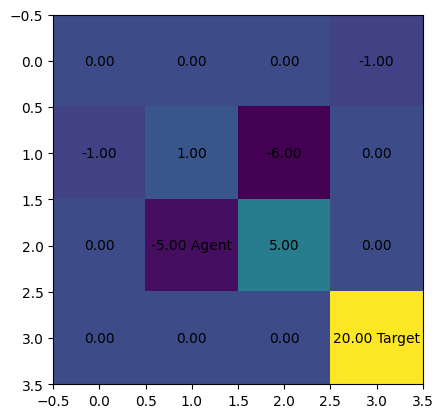

Step 4 Reward 5
Current time: 4


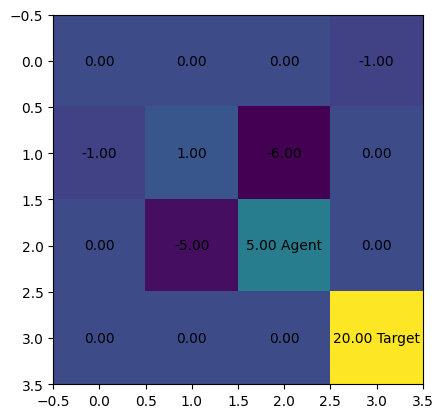

Step 5 Reward 0
Current time: 5


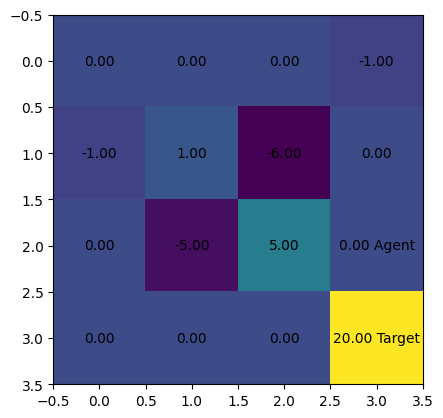

Step 6 Reward 20
Current time: 6


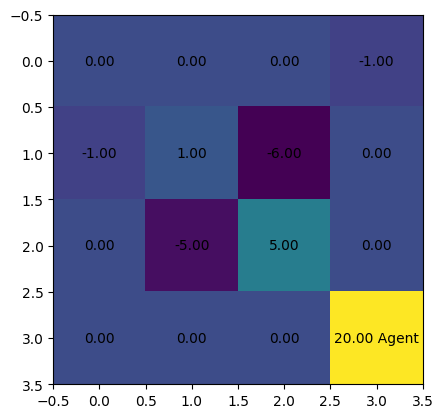

Total reward: 21


In [ ]:
sarsaLR3 = AgentTrial(AgentSARSA(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.05, epsilon = 1.0, epsilon_min = 0.01), 'SARSA')

sarsaLR3.train()

sarsaLR3.greedy_eval()

sarsaLR3.print_q_tables()

sarsaLR3.plot()

sarsaLR3.greedy_walk()

## SARSA with Optuna Hyperparamter search on Discount Factor and Learning Rate

In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00


In [ ]:
def objective_sarsa(trial):
    discount_factor = trial.suggest_float("discount_factor", 0.7, 0.99, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)

    sarsa_agent = AgentSARSA(
        discount_factor=discount_factor,
        learning_rate=learning_rate
    )

    train_episodes = 1000
    total_rewards, _ = sarsa_agent.train(num_episodes=train_episodes)

    return np.mean(total_rewards)

In [ ]:
study_sarsa = optuna.create_study(direction="maximize")
study_sarsa.optimize(objective_sarsa, n_trials=200)

[I 2023-12-07 19:26:54,767] A new study created in memory with name: no-name-030d6dcf-cb05-4fea-b3c9-7916b54b1356
[I 2023-12-07 19:26:54,884] Trial 0 finished with value: 6.423 and parameters: {'discount_factor': 0.8575758430606704, 'learning_rate': 0.025688261102187207}. Best is trial 0 with value: 6.423.
[I 2023-12-07 19:26:54,961] Trial 1 finished with value: 15.373 and parameters: {'discount_factor': 0.7046596859884039, 'learning_rate': 0.4107807138290263}. Best is trial 1 with value: 15.373.
[I 2023-12-07 19:26:55,071] Trial 2 finished with value: 17.154 and parameters: {'discount_factor': 0.8986581346232665, 'learning_rate': 0.1397883146746952}. Best is trial 2 with value: 17.154.
[I 2023-12-07 19:26:55,150] Trial 3 finished with value: 16.025 and parameters: {'discount_factor': 0.7413176464122014, 'learning_rate': 0.2886140224316205}. Best is trial 2 with value: 17.154.
[I 2023-12-07 19:26:55,247] Trial 4 finished with value: 13.472 and parameters: {'discount_factor': 0.80386136

Best Hyperparameters:
{'discount_factor': 0.8475565498668792, 'learning_rate': 0.17646538046010768}
Initial Q-Table
[[0.14282091 0.28355306 0.65748365 0.93607471]
 [0.17394426 0.21474705 0.99536098 0.30040612]
 [0.55164457 0.54797594 0.49951798 0.52842826]
 [0.97036539 0.45219349 0.75030389 0.56693263]
 [0.95669568 0.30724823 0.43528936 0.69665456]
 [0.38036647 0.50354581 0.20541045 0.67091217]
 [0.48747777 0.95788946 0.01947969 0.15515891]
 [0.04471885 0.24117598 0.25909697 0.10294602]
 [0.24956385 0.24594941 0.00416877 0.7244742 ]
 [0.22388152 0.01596849 0.38078367 0.86240473]
 [0.14484229 0.14165171 0.75227485 0.91712959]
 [0.54638699 0.08533871 0.76473317 0.46386952]
 [0.61047744 0.98090022 0.73136131 0.77895864]
 [0.91094158 0.27007549 0.89231939 0.29730253]
 [0.0890246  0.4217027  0.00399194 0.30507094]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 5.64700755  3.99864615  9.04718531  5.45210234]
 [ 8.08981382 10.67454723  4.02800799  5.09287607]
 [-0.22298424 

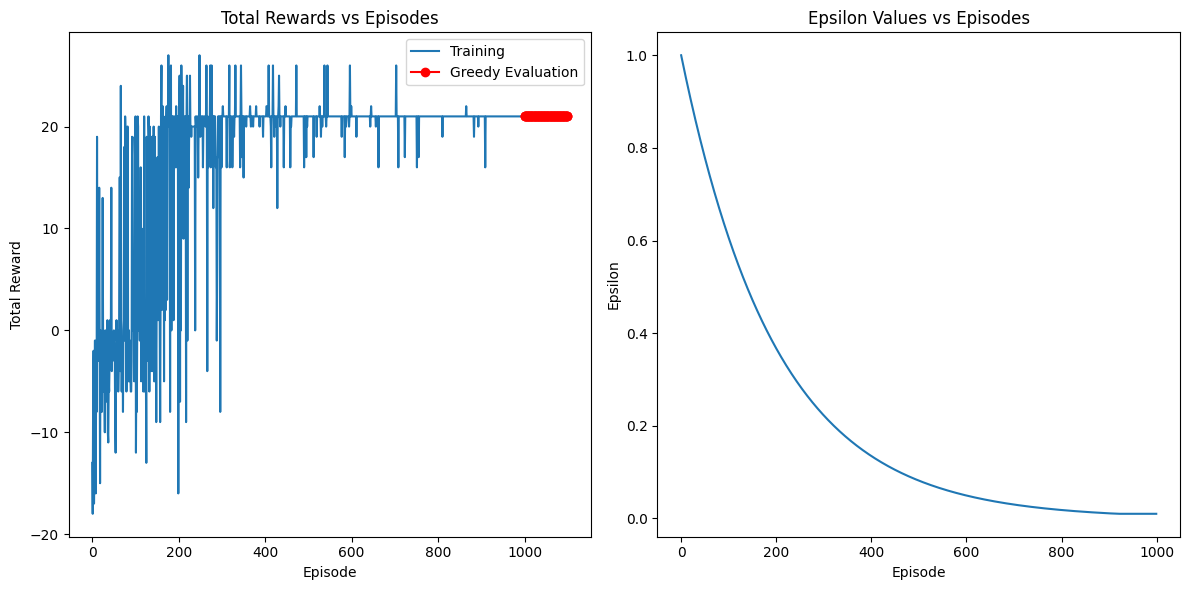

Current time: 0


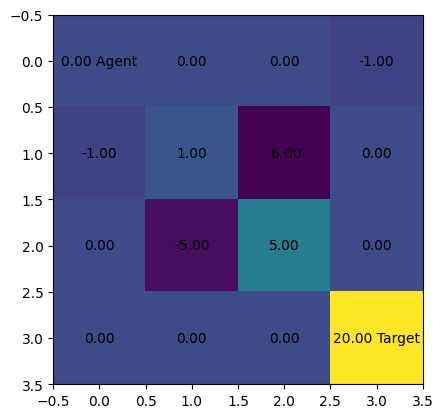

Step 1 Reward 0
Current time: 1


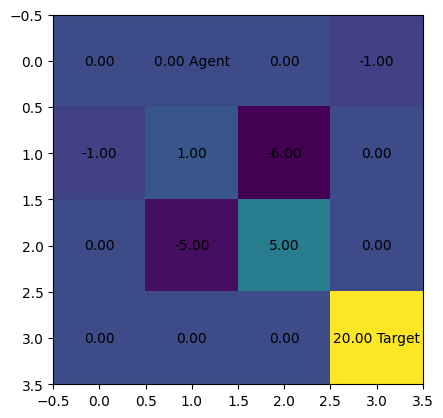

Step 2 Reward 1
Current time: 2


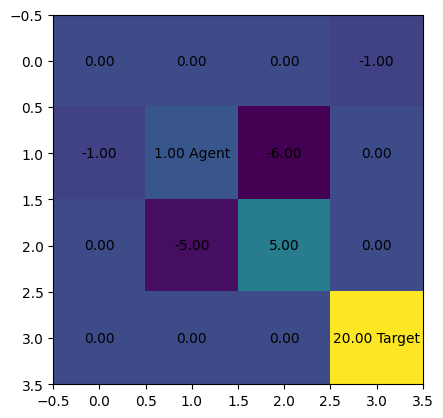

Step 3 Reward -5
Current time: 3


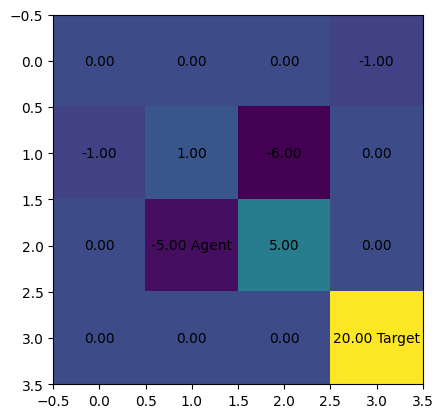

Step 4 Reward 5
Current time: 4


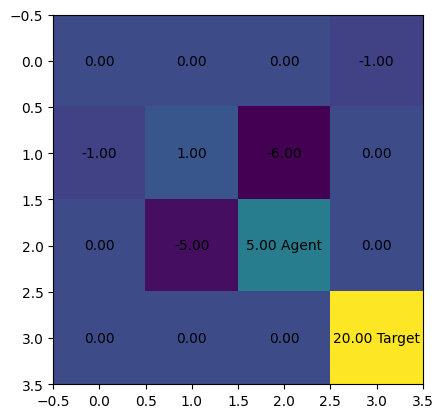

Step 5 Reward 0
Current time: 5


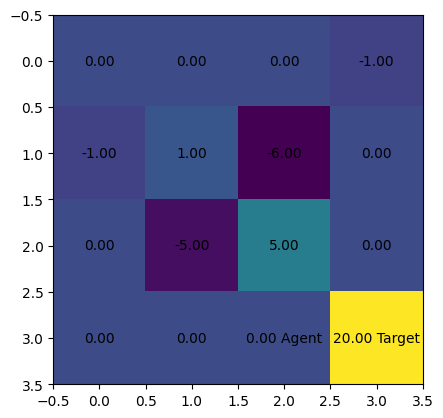

Step 6 Reward 20
Current time: 6


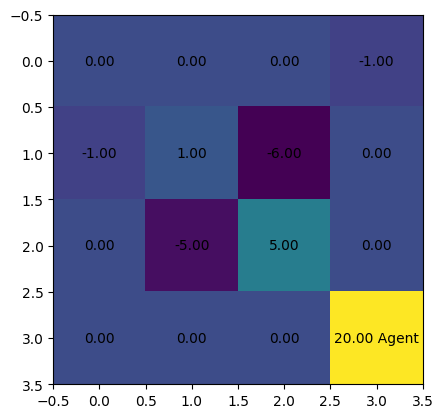

Total reward: 21


In [ ]:
# Get the best hyperparameters
best_sarsa_params = study_sarsa.best_params
print("Best Hyperparameters:")
print(best_sarsa_params)

sarsaBest = AgentTrial(AgentSARSA(**best_sarsa_params), 'SARSA')

sarsaBest.train()

sarsaBest.greedy_eval()

sarsaBest.print_q_tables()

sarsaBest.plot()

sarsaBest.greedy_walk()

## Double Q Learning

In [ ]:
class AgentDoubleQ(GridWorldEnv):
    def __init__(self, discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01):
        super().__init__()
        # Q-table initialization
        self.Q1_table = np.random.rand(len(self.states), len(self.actions))
        self.Q1_table[self.state_space_flat[self.states.index(self.target_state)]] = np.zeros(len(self.actions))
        self.Q2_table = np.random.rand(len(self.states), len(self.actions))
        self.Q2_table[self.state_space_flat[self.states.index(self.target_state)]] = np.zeros(len(self.actions))

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Exploration
        else:
            flat_state = self.flatten_state(state)
            return np.argmax(np.average((self.Q1_table[flat_state, :], self.Q2_table[flat_state, :]), axis=0))  # Exploitation

    def update_q_table(self, state, action, reward, next_state, next_action):
        # Double Q update rule
        flat_state = self.flatten_state(state)
        flat_next_state = self.flatten_state(next_state)

        if np.random.rand() < 0.5:
            # Update Q1_table
            max_action = np.argmax(self.Q1_table[flat_next_state, :])
            current_value = self.Q1_table[flat_state, action]
            next_value = self.Q2_table[flat_next_state, max_action]
            updated_value = current_value + self.learning_rate * (reward + self.discount_factor * next_value - current_value)
            self.Q1_table[flat_state, action] = updated_value
        else:
            # Update Q2_table
            max_action = np.argmax(self.Q2_table[flat_next_state, :])
            current_value = self.Q2_table[flat_state, action]
            next_value = self.Q1_table[flat_next_state, max_action]
            updated_value = current_value + self.learning_rate * (reward + self.discount_factor * next_value - current_value)
            self.Q2_table[flat_state, action] = updated_value

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def train(self, num_episodes=1000):
        total_rewards_per_episode = []
        epsilon_values = []

        for episode in range(num_episodes):
            state = self.reset()
            action = self.choose_action(state)
            total_reward = 0

            while True:
                next_state, reward, done, _ = self.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)

                total_reward += reward
                state = next_state
                action = next_action

                if done:
                    break

            total_rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.decay_epsilon()

        return total_rewards_per_episode, epsilon_values

    def evaluate_greedy_policy(self, num_episodes=10):
        total_rewards_per_episode = []

        for episode in range(num_episodes):
            state = self.reset()
            total_reward = 0
            while True:
                flat_state = self.flatten_state(state)
                action = np.argmax(np.average((self.Q1_table[flat_state, :], self.Q2_table[flat_state, :]), axis=0))
                next_state, reward, done, _ = self.step(action)

                total_reward += reward
                state = next_state

                if done:
                    break

            total_rewards_per_episode.append(total_reward)

        return total_rewards_per_episode

    def visualize_greedy_policy(self, renderMode = 'Array'):
        state = self.reset()
        total_reward = 0
        self.render(renderMode)
        while True:
            flat_state = self.flatten_state(state)
            action = np.argmax(np.average((self.Q1_table[flat_state, :], self.Q2_table[flat_state, :]), axis=0))
            next_state, reward, done, _ = self.step(action)

            total_reward += reward
            state = next_state
            print(f"Step {self.current_time} Reward {reward}")
            self.render(renderMode)
            if done:
                break
        print(f"Total reward: {total_reward}")

Initial Q1-Table
[[0.41245102 0.79578729 0.01832406 0.90581434]
 [0.33640745 0.52337226 0.62725099 0.80775469]
 [0.45742077 0.48620148 0.41680364 0.55020616]
 [0.45481415 0.47003557 0.97008447 0.09049022]
 [0.17742008 0.33803742 0.68840985 0.1553019 ]
 [0.27898951 0.82866991 0.38219673 0.24666828]
 [0.07076934 0.83615439 0.4566701  0.15118139]
 [0.69489745 0.97660361 0.77883798 0.20506037]
 [0.73067733 0.68555979 0.76219377 0.07393381]
 [0.21312221 0.55347632 0.91186325 0.18247158]
 [0.93848556 0.94439005 0.18555441 0.37793023]
 [0.04017138 0.64236867 0.60433376 0.27800773]
 [0.42173469 0.079794   0.61714639 0.5676018 ]
 [0.11275505 0.14539302 0.86908929 0.44286211]
 [0.83660957 0.60760057 0.42378937 0.30819862]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.05270567 0.96324887 0.2850404  0.78310006]
 [0.24249325 0.15023359 0.53730298 0.56907362]
 [0.91575741 0.64253036 0.03411583 0.92514365]
 [0.51489911 0.84383163 0.27996648 0.45466144]
 [0.81672164 0.38811132 0

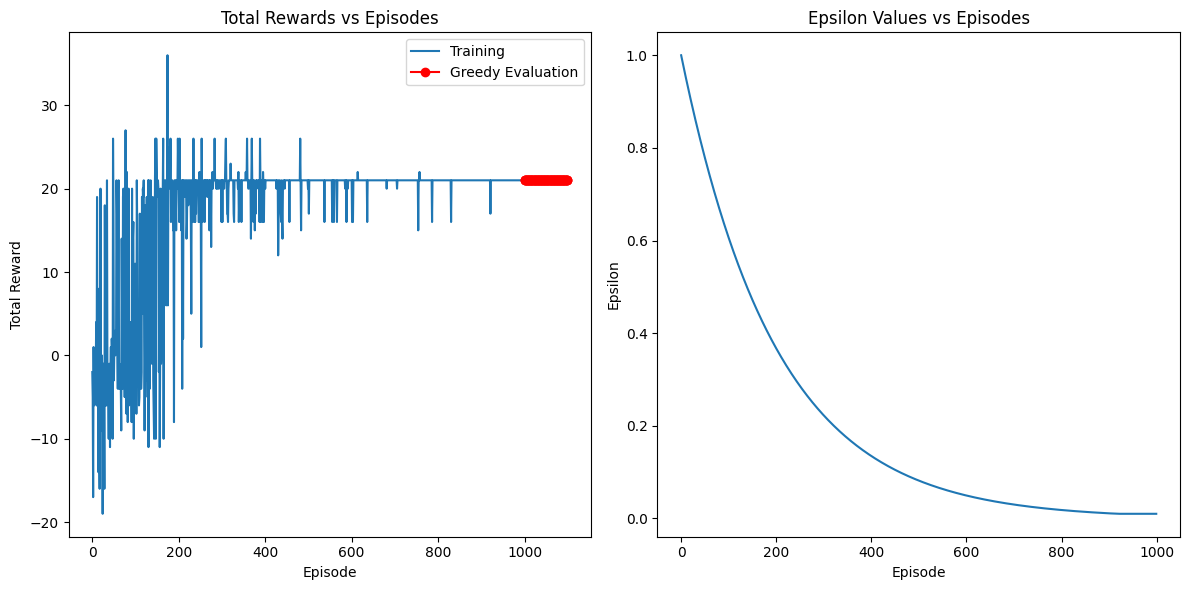

Current time: 0


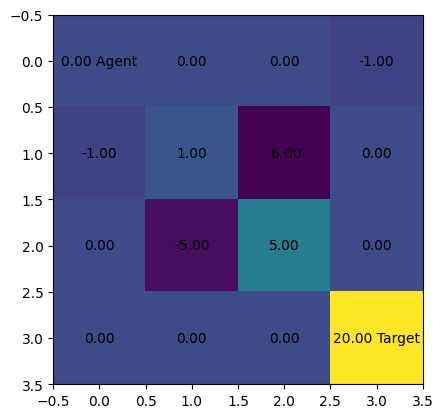

Step 1 Reward 0
Current time: 1


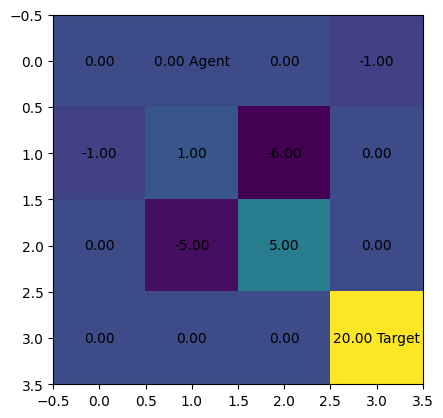

Step 2 Reward 1
Current time: 2


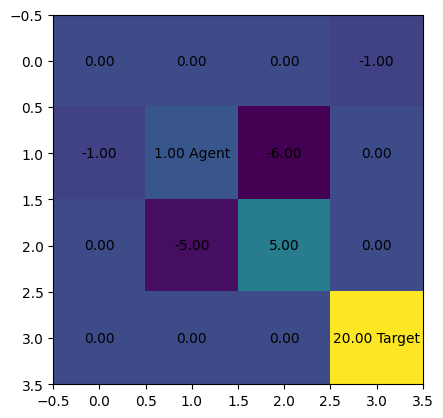

Step 3 Reward -5
Current time: 3


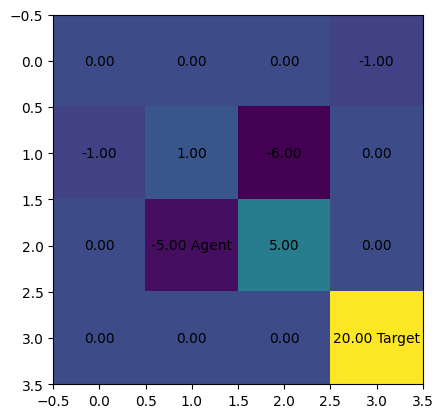

Step 4 Reward 5
Current time: 4


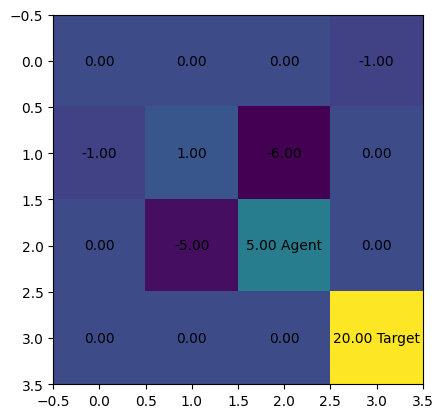

Step 5 Reward 0
Current time: 5


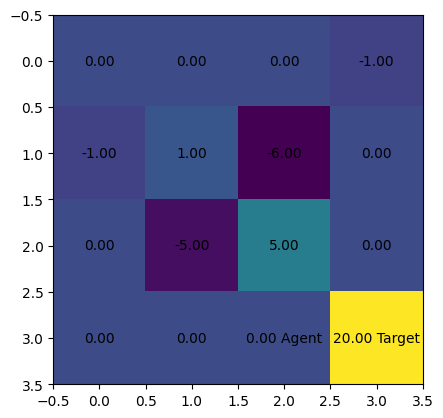

Step 6 Reward 20
Current time: 6


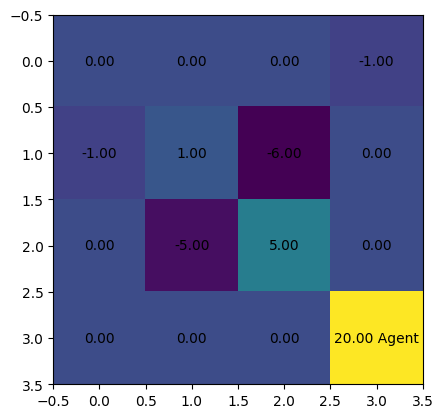

Total reward: 21


In [ ]:
doubleQBase = AgentTrial(AgentDoubleQ(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQBase.train()

doubleQBase.greedy_eval()

doubleQBase.print_q_tables()

doubleQBase.plot()

doubleQBase.greedy_walk()

## Double Q Learning with experimentation on Discount Factor hyperparameter

Initial Q1-Table
[[0.82454571 0.66218611 0.25882209 0.47932691]
 [0.13985427 0.54195157 0.98118299 0.32504554]
 [0.96857177 0.50183584 0.67938521 0.8941793 ]
 [0.99506822 0.76066934 0.38198966 0.73729904]
 [0.10070082 0.7959645  0.38082274 0.77322693]
 [0.24464332 0.84549802 0.64664576 0.28416408]
 [0.76839273 0.89787098 0.09227749 0.18328454]
 [0.83740375 0.02432458 0.41108986 0.37902914]
 [0.0723465  0.54959856 0.41694132 0.96095536]
 [0.21761685 0.15896989 0.20487341 0.35993964]
 [0.79719032 0.76584465 0.66605394 0.57041458]
 [0.28964129 0.80666832 0.4514412  0.42042057]
 [0.25515162 0.66985201 0.52162528 0.01709445]
 [0.92581308 0.95802979 0.19368051 0.19775286]
 [0.35199806 0.55045794 0.98815085 0.86394444]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.54512995 0.05816435 0.63010785 0.32454715]
 [0.56453579 0.74011479 0.27145474 0.7213452 ]
 [0.01304538 0.19761585 0.18243933 0.06801668]
 [0.22819375 0.09180291 0.28780965 0.54315358]
 [0.06353945 0.59289596 0

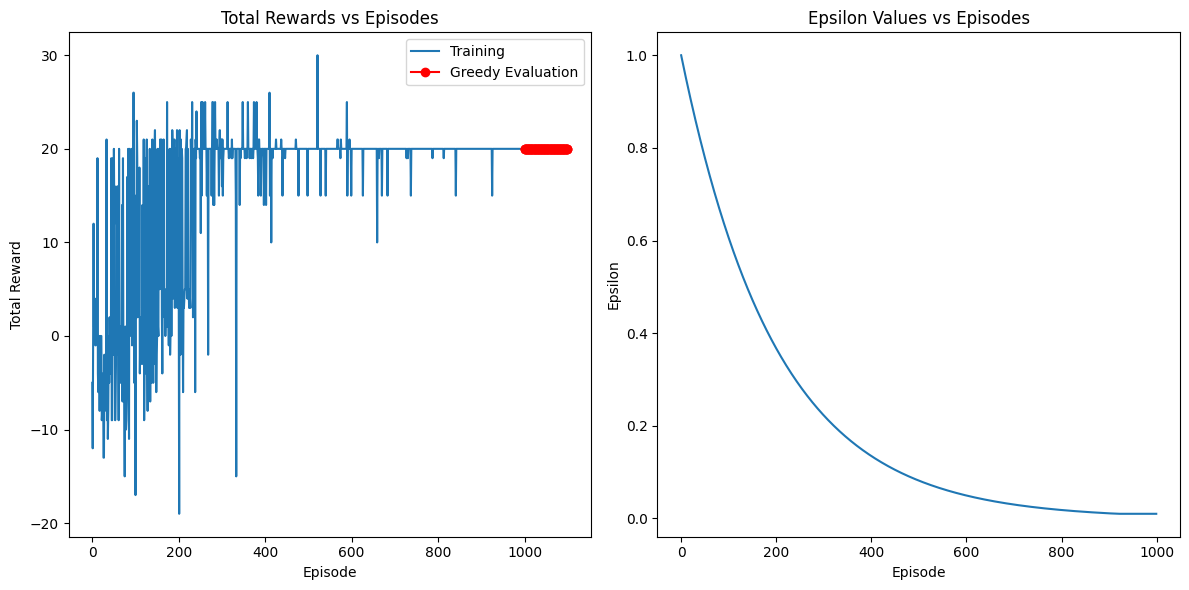

Current time: 0


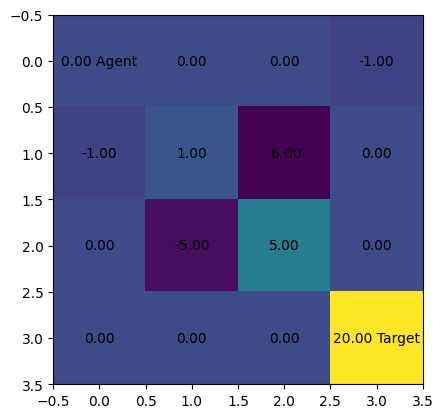

Step 1 Reward 0
Current time: 1


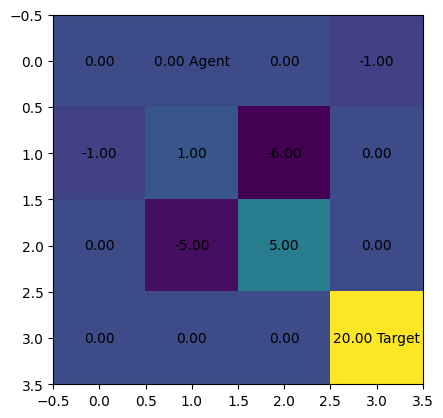

Step 2 Reward 1
Current time: 2


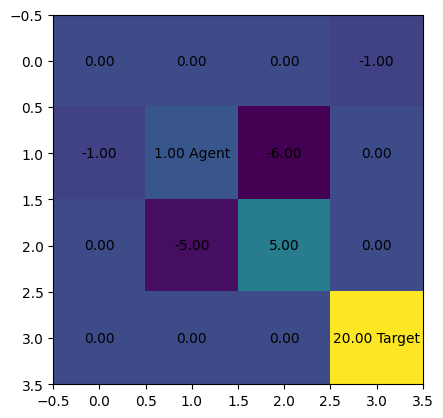

Step 3 Reward -6
Current time: 3


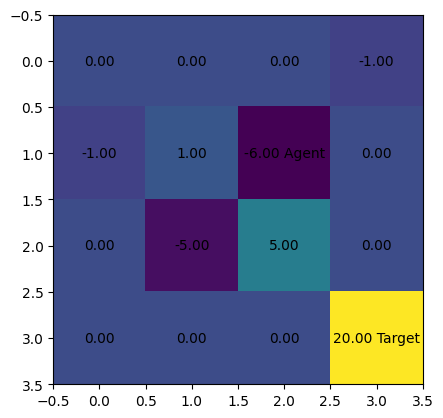

Step 4 Reward 5
Current time: 4


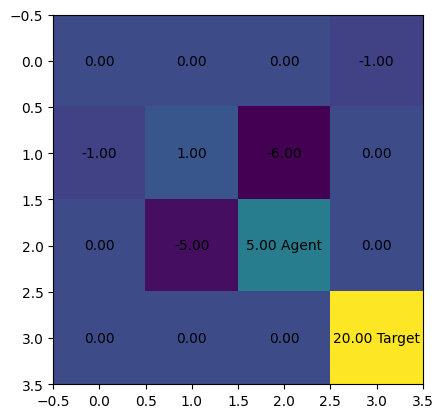

Step 5 Reward 0
Current time: 5


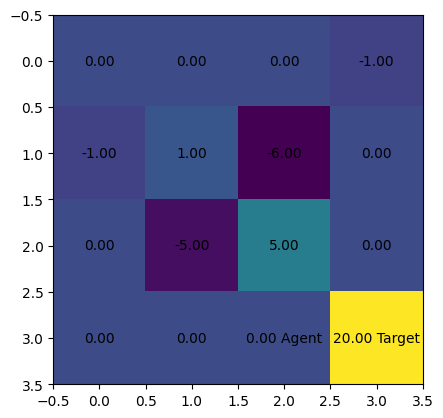

Step 6 Reward 20
Current time: 6


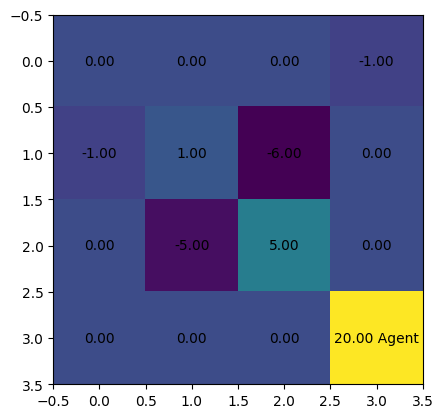

Total reward: 20


In [ ]:
doubleQDiscount1 = AgentTrial(AgentDoubleQ(discount_factor = 0.7, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQDiscount1.train()

doubleQDiscount1.greedy_eval()

doubleQDiscount1.print_q_tables()

doubleQDiscount1.plot()

doubleQDiscount1.greedy_walk()

Initial Q1-Table
[[0.21680807 0.79185458 0.66501108 0.84140254]
 [0.54260822 0.68924116 0.04256166 0.00246103]
 [0.78789862 0.22081584 0.04880382 0.35054269]
 [0.23610295 0.38055487 0.72586053 0.10802825]
 [0.98189101 0.44000101 0.3957959  0.93183132]
 [0.99211366 0.34462901 0.43282304 0.55299872]
 [0.06759013 0.75010213 0.8718154  0.26337495]
 [0.63507719 0.7688722  0.71084189 0.84289491]
 [0.66404096 0.21621995 0.20222223 0.13777278]
 [0.76777503 0.50120869 0.69502031 0.80858839]
 [0.14935135 0.57558795 0.80182317 0.82142966]
 [0.31030445 0.93994205 0.50024099 0.83698829]
 [0.45627805 0.93569932 0.16264484 0.73541407]
 [0.53626797 0.72762572 0.02037645 0.90740837]
 [0.88476726 0.58450365 0.37509207 0.12837036]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.47484061 0.17217227 0.3914997  0.42666402]
 [0.38448377 0.10532661 0.6070752  0.77796859]
 [0.48423923 0.7546937  0.26413377 0.7221774 ]
 [0.75564965 0.39883133 0.79302989 0.21023713]
 [0.37520698 0.75262989 0

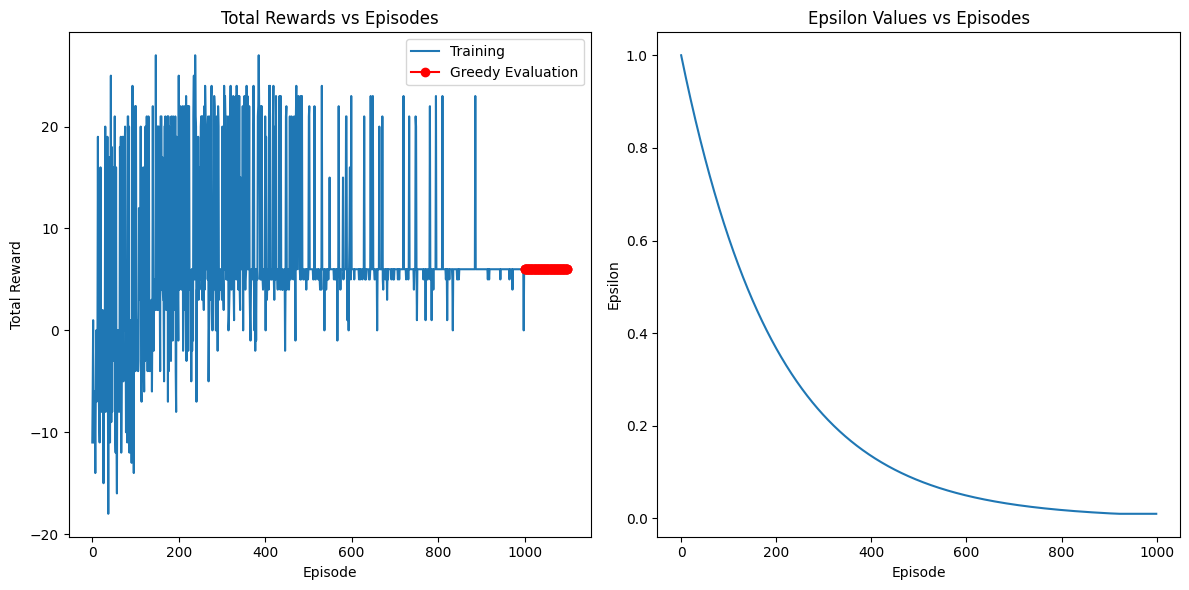

Current time: 0


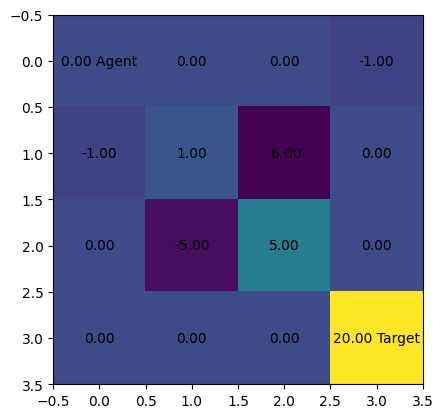

Step 1 Reward 0
Current time: 1


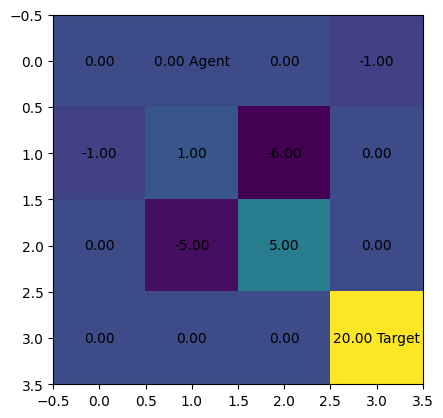

Step 2 Reward 1
Current time: 2


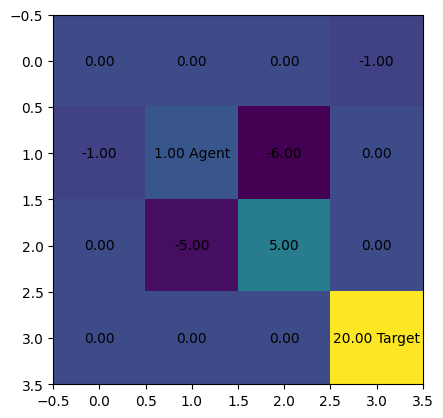

Step 3 Reward 0
Current time: 3


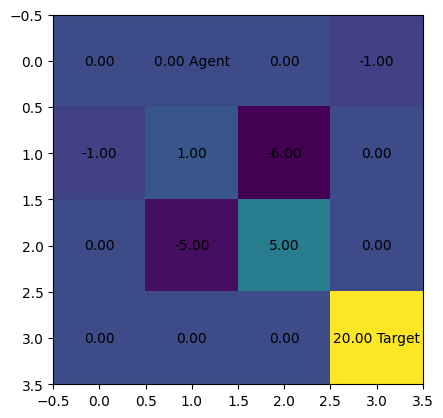

Step 4 Reward 1
Current time: 4


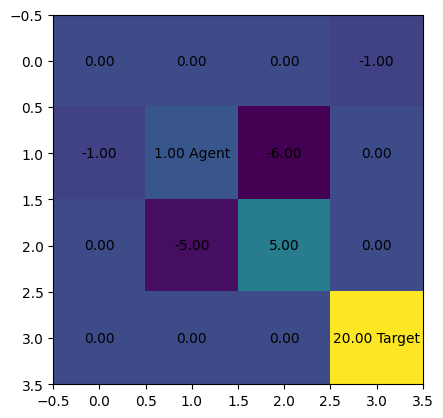

Step 5 Reward 0
Current time: 5


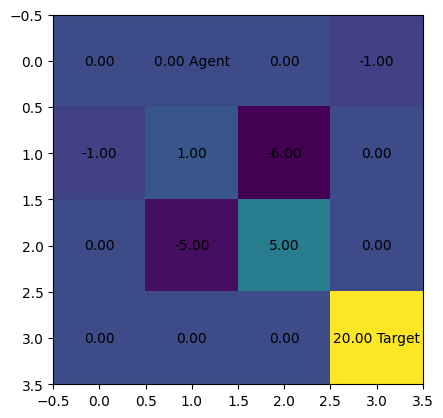

Step 6 Reward 1
Current time: 6


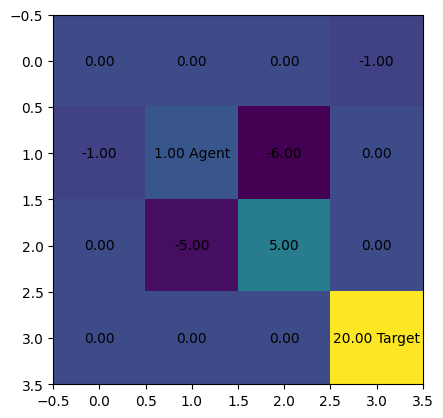

Step 7 Reward 0
Current time: 7


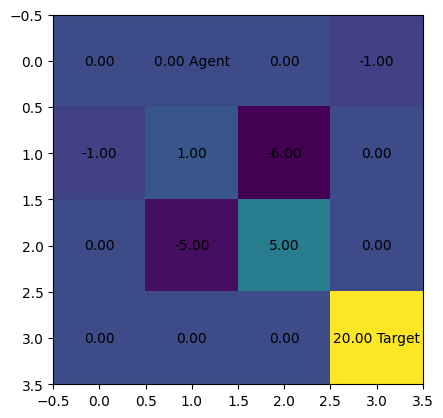

Step 8 Reward 1
Current time: 8


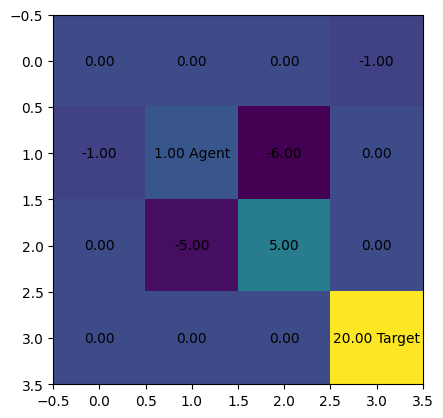

Step 9 Reward 0
Current time: 9


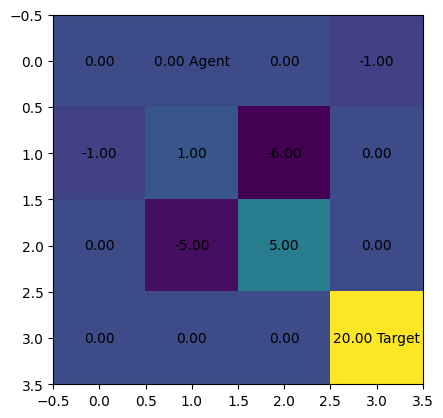

Step 10 Reward 1
Current time: 10


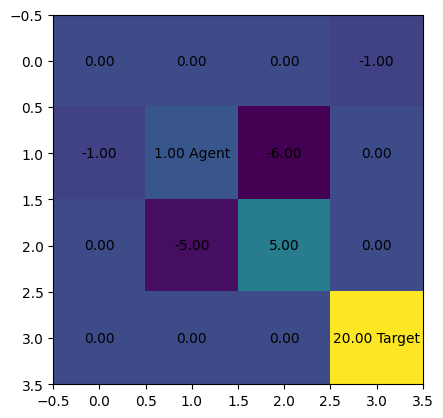

Step 11 Reward 0
Current time: 11


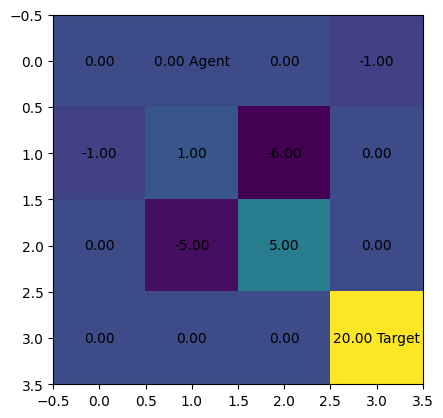

Step 12 Reward 1
Current time: 12


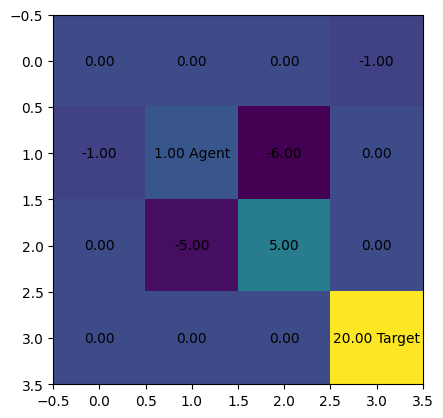

Step 13 Reward 0
Current time: 13


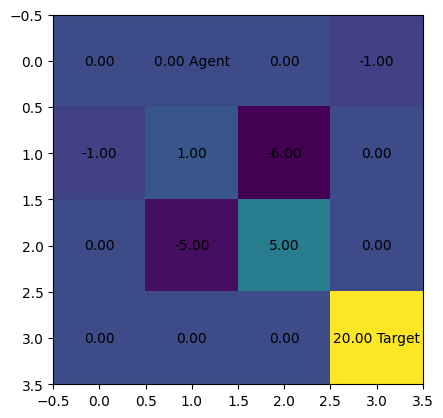

Total reward: 6


In [ ]:
doubleQDiscount2 = AgentTrial(AgentDoubleQ(discount_factor = 0.4, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQDiscount2.train()

doubleQDiscount2.greedy_eval()

doubleQDiscount2.print_q_tables()

doubleQDiscount2.plot()

doubleQDiscount2.greedy_walk()

Initial Q1-Table
[[2.16158330e-02 3.40933734e-01 5.41814067e-01 3.39217052e-01]
 [7.11180032e-01 1.91682466e-01 6.09071796e-01 6.78136685e-01]
 [8.61508830e-01 7.13074701e-01 7.98814971e-01 1.28124813e-02]
 [5.52031685e-01 2.65976368e-01 3.96098974e-01 4.29484322e-01]
 [2.45215250e-01 6.14759987e-01 4.94470422e-01 3.80487275e-01]
 [4.19427412e-01 9.27382268e-01 8.68664579e-01 5.32152235e-01]
 [9.07032989e-01 5.81058302e-01 6.98995896e-01 9.61555901e-01]
 [9.35956099e-01 2.63682504e-01 6.06647084e-01 9.85831105e-01]
 [8.11083476e-01 7.23219460e-01 1.50959753e-01 1.69546488e-01]
 [9.06596046e-01 9.42130056e-01 9.01803543e-01 2.71684623e-01]
 [6.54234638e-01 4.75707557e-01 6.07666213e-01 6.21776539e-01]
 [9.78035407e-01 8.63268779e-01 6.58312781e-01 6.63408011e-01]
 [9.85038016e-01 4.24351224e-01 5.71155468e-01 5.08541126e-02]
 [3.56039026e-01 1.76112212e-04 7.80599470e-01 1.61564609e-01]
 [1.04788983e-01 8.68698713e-01 3.65671255e-01 2.12823295e-01]
 [0.00000000e+00 0.00000000e+00 0.0000

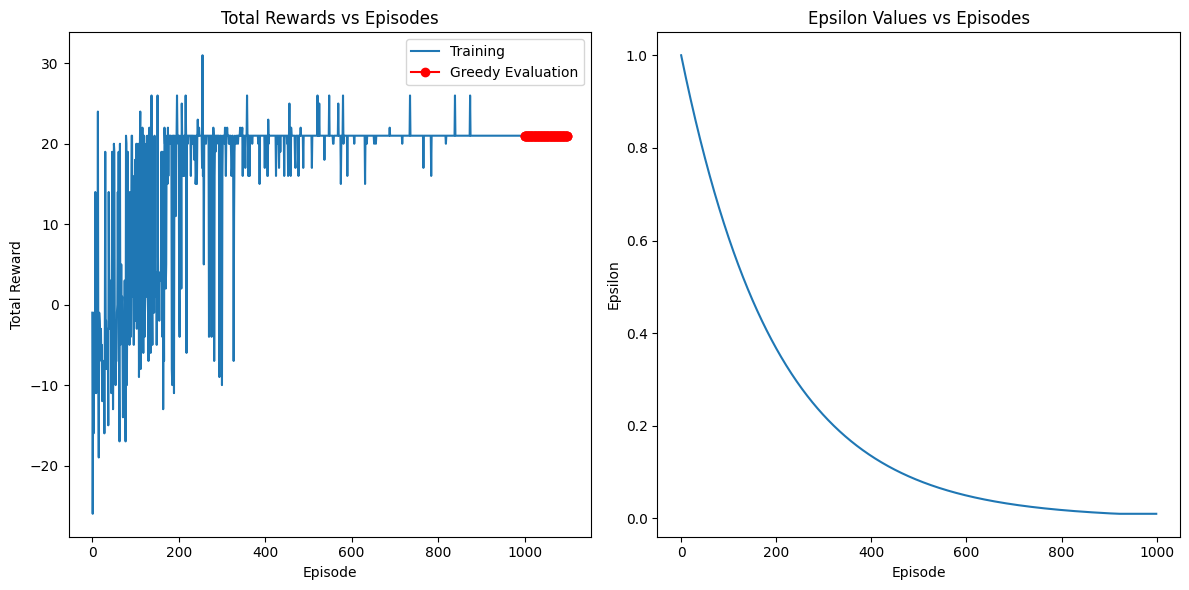

Current time: 0


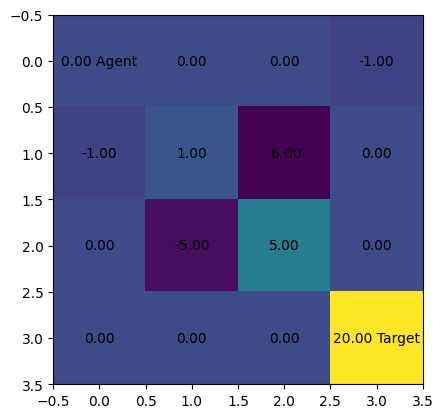

Step 1 Reward 0
Current time: 1


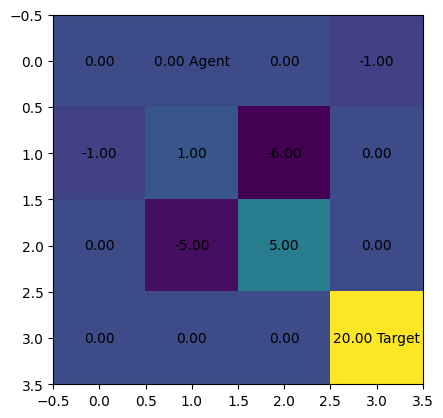

Step 2 Reward 1
Current time: 2


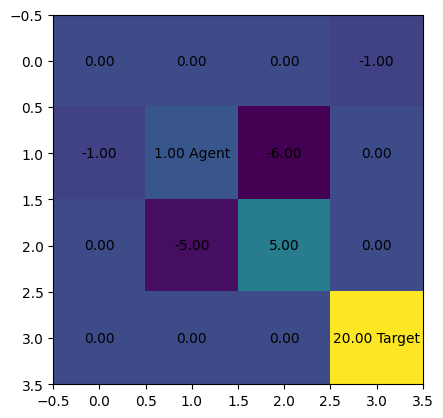

Step 3 Reward -5
Current time: 3


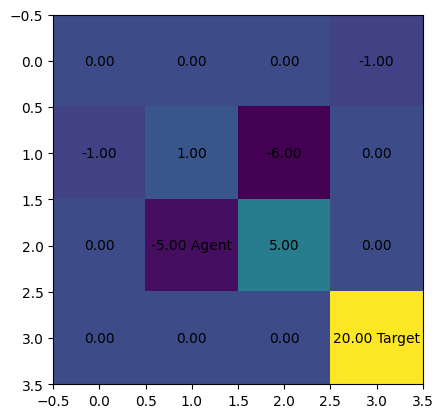

Step 4 Reward 5
Current time: 4


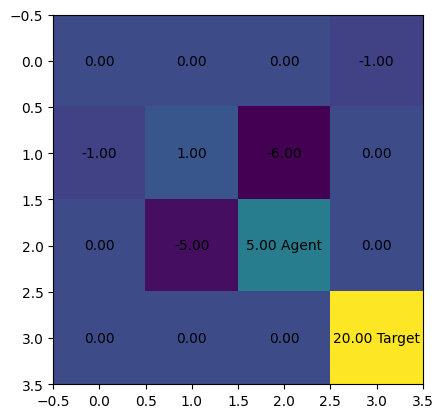

Step 5 Reward 0
Current time: 5


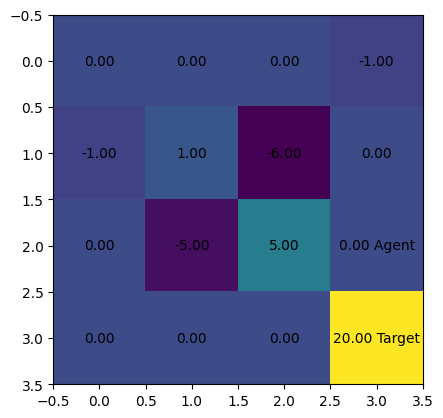

Step 6 Reward 20
Current time: 6


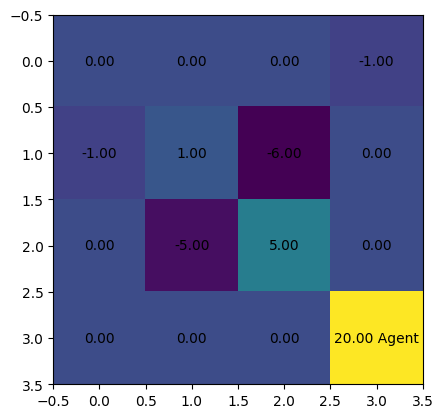

Total reward: 21


In [ ]:
doubleQDiscount3 = AgentTrial(AgentDoubleQ(discount_factor = 0.99, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQDiscount3.train()

doubleQDiscount3.greedy_eval()

doubleQDiscount3.print_q_tables()

doubleQDiscount3.plot()

doubleQDiscount3.greedy_walk()

## Double Q Learning with experimentation on Learning Rate hyperparameter

Initial Q1-Table
[[8.19318404e-01 9.56409128e-01 3.86147672e-01 4.73453983e-01]
 [8.55464863e-01 3.27871495e-01 5.01879269e-04 1.23454860e-01]
 [3.73343947e-01 4.13554676e-02 5.49404384e-01 1.97091961e-01]
 [8.86391467e-01 4.41548135e-01 3.07624937e-01 5.98799235e-02]
 [5.20079802e-01 2.23927178e-01 5.29035623e-01 3.31751270e-01]
 [9.77615859e-01 3.32290271e-01 2.44699689e-01 2.16942229e-01]
 [9.29366067e-01 9.54124370e-01 7.35195845e-01 5.13002989e-01]
 [9.49454412e-01 7.30167581e-01 4.15115364e-01 6.73677065e-01]
 [9.67822053e-01 9.22928106e-02 9.50354817e-01 1.56702220e-01]
 [1.55349651e-01 8.85676347e-01 9.09484746e-01 3.11096899e-01]
 [8.07866995e-01 5.14520371e-01 3.48316654e-01 5.07169398e-01]
 [7.49487030e-01 3.84681775e-02 2.71609910e-01 5.76245210e-01]
 [3.25474077e-01 2.68324053e-02 1.92094879e-01 2.43197606e-01]
 [9.35680011e-01 4.56525455e-01 3.72664876e-01 2.97538003e-01]
 [6.19449539e-01 5.41647949e-01 7.51210314e-01 4.01441231e-01]
 [0.00000000e+00 0.00000000e+00 0.0000

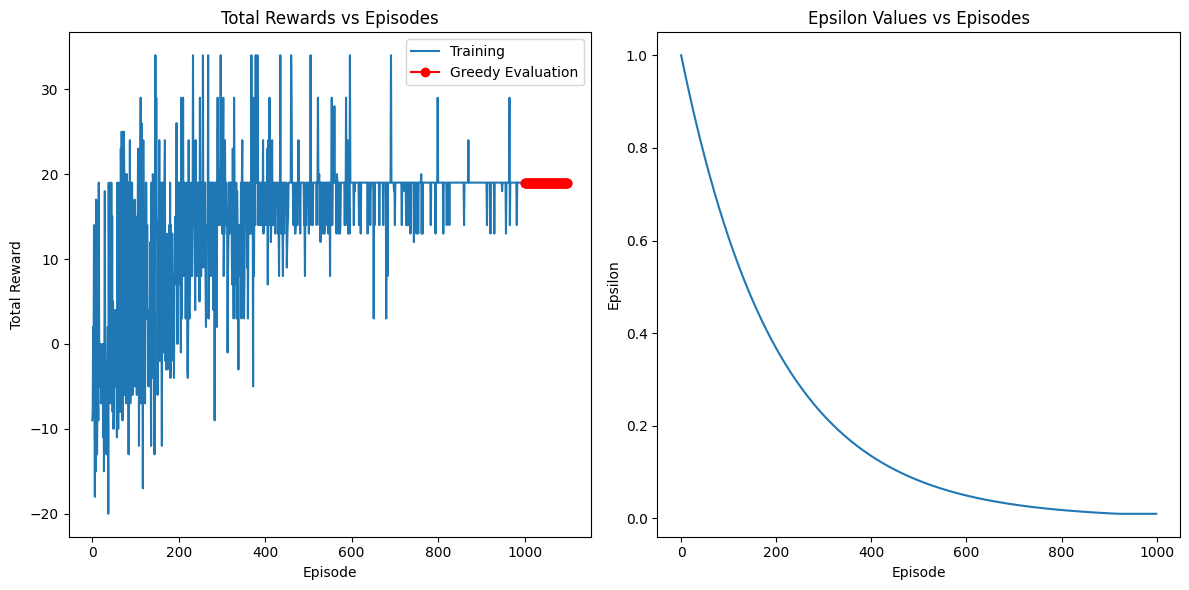

Current time: 0


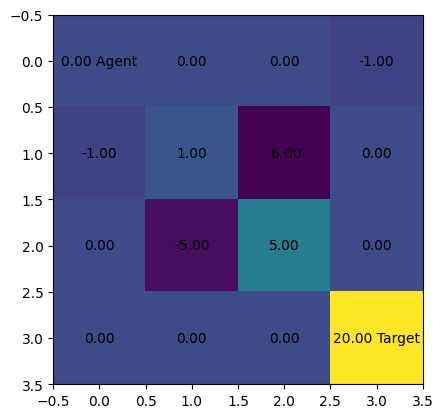

Step 1 Reward 0
Current time: 1


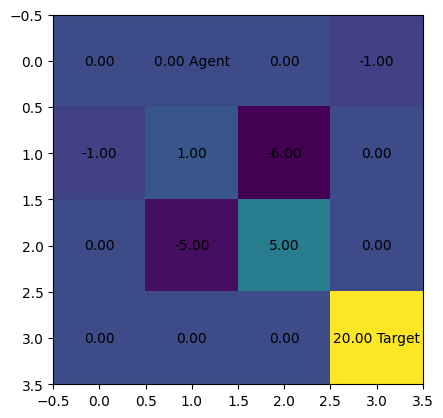

Step 2 Reward 0
Current time: 2


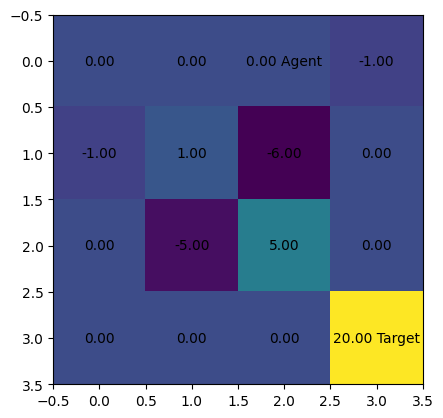

Step 3 Reward -1
Current time: 3


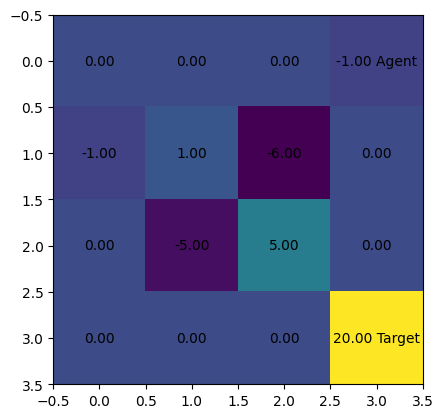

Step 4 Reward 0
Current time: 4


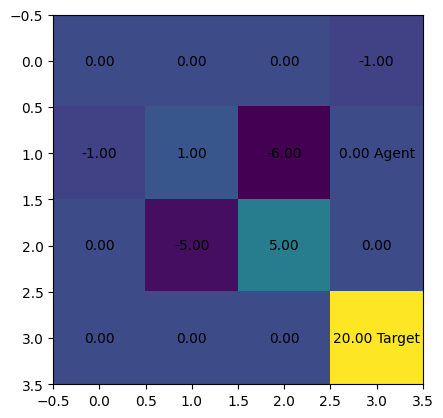

Step 5 Reward 0
Current time: 5


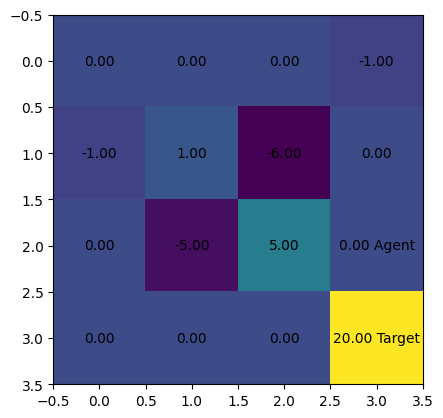

Step 6 Reward 5
Current time: 6


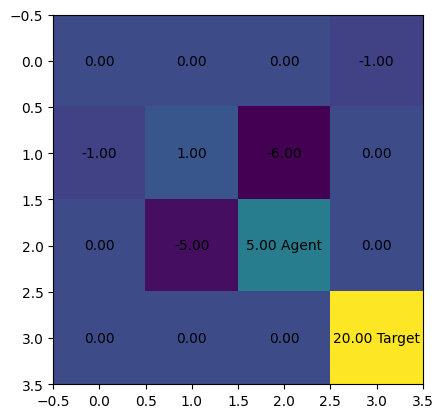

Step 7 Reward 0
Current time: 7


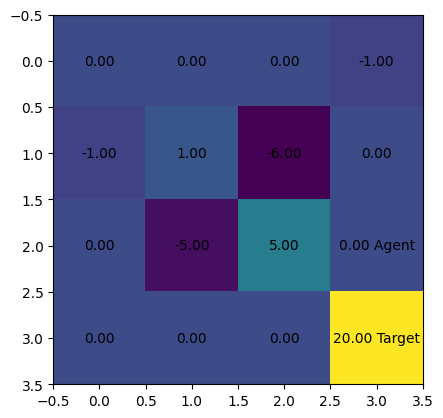

Step 8 Reward 5
Current time: 8


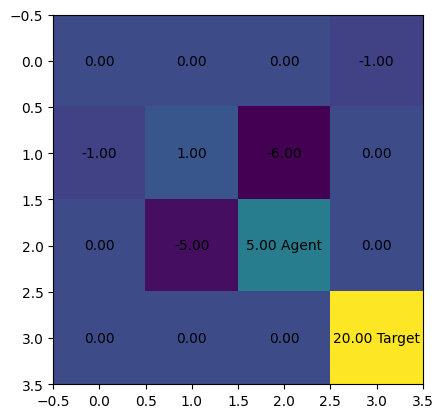

Step 9 Reward 0
Current time: 9


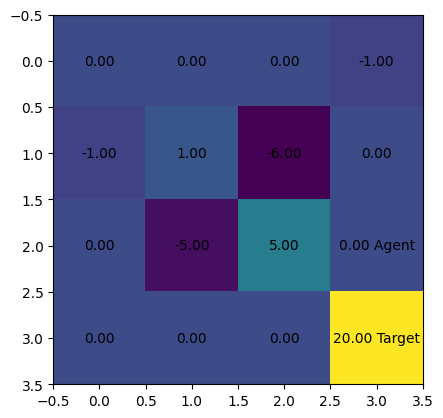

Step 10 Reward 5
Current time: 10


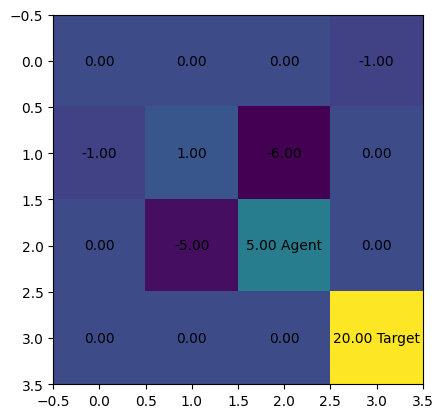

Step 11 Reward 0
Current time: 11


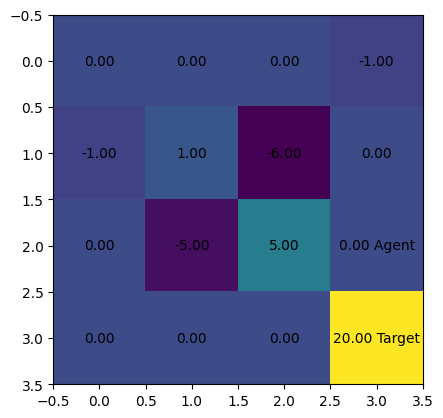

Step 12 Reward 5
Current time: 12


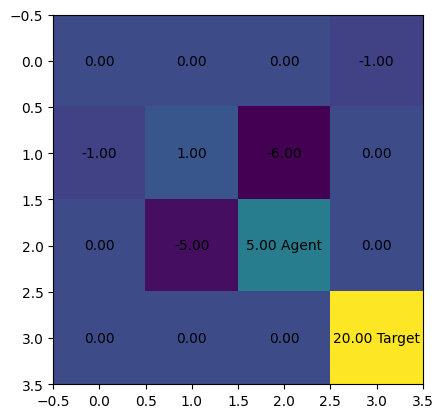

Step 13 Reward 0
Current time: 13


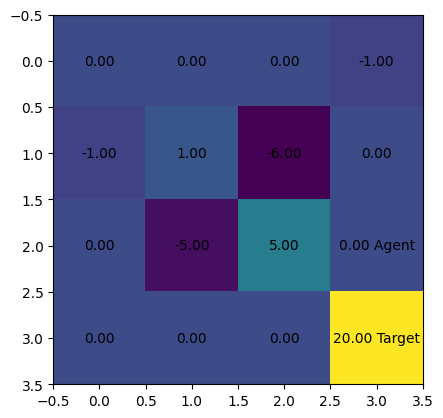

Total reward: 19


In [ ]:
doubleQLR1 = AgentTrial(AgentDoubleQ(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.5, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQLR1.train()

doubleQLR1.greedy_eval()

doubleQLR1.print_q_tables()

doubleQLR1.plot()

doubleQLR1.greedy_walk()

Initial Q1-Table
[[0.4842224  0.7995579  0.85812426 0.36764388]
 [0.83807897 0.51504515 0.72050301 0.32277431]
 [0.63343532 0.21263591 0.47930598 0.38974954]
 [0.34061875 0.29383046 0.9198001  0.9258933 ]
 [0.84694898 0.20799502 0.12497586 0.60489132]
 [0.55674398 0.54611763 0.07964013 0.11683978]
 [0.96983791 0.08088197 0.50158789 0.41646507]
 [0.88432914 0.86606947 0.34289429 0.70725903]
 [0.30462008 0.33604994 0.20431682 0.5535034 ]
 [0.7777732  0.50189972 0.42139116 0.56311422]
 [0.27443342 0.31563288 0.9291695  0.82366627]
 [0.47103253 0.87225267 0.89114559 0.3513402 ]
 [0.95989173 0.56160915 0.90947663 0.91186568]
 [0.81440279 0.83379006 0.16323939 0.49332412]
 [0.98074557 0.35015139 0.54001496 0.97669789]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.33117798 0.42517708 0.77142771 0.72105397]
 [0.42613343 0.12245267 0.05297589 0.33966819]
 [0.95206473 0.43526505 0.01249769 0.01260196]
 [0.74601404 0.0811177  0.50969978 0.61591536]
 [0.65018037 0.77284131 0

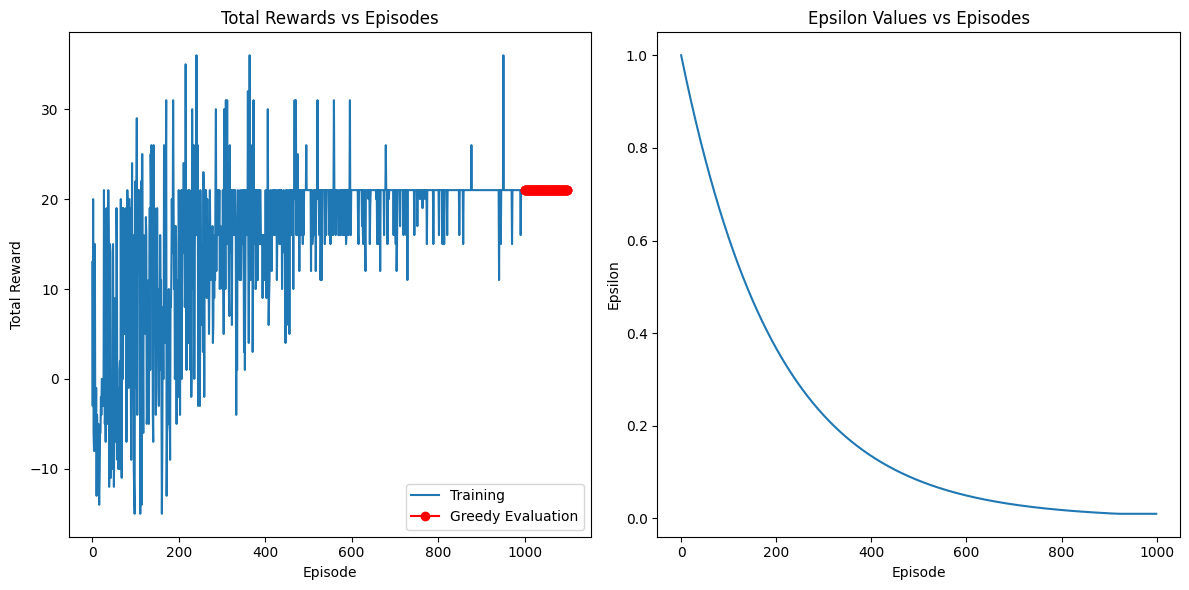

Current time: 0


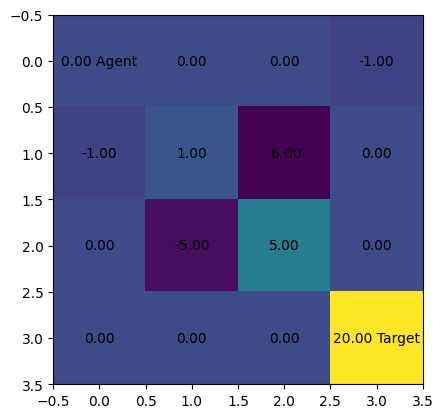

Step 1 Reward 0
Current time: 1


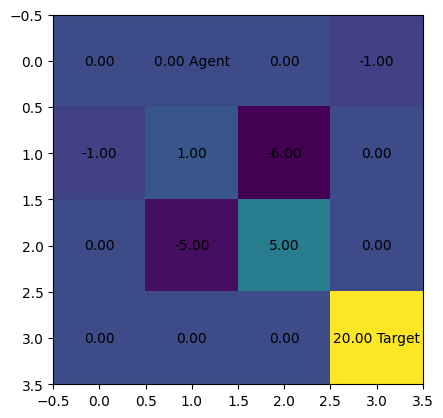

Step 2 Reward 1
Current time: 2


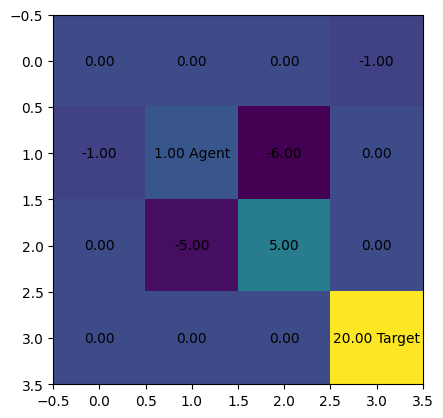

Step 3 Reward -5
Current time: 3


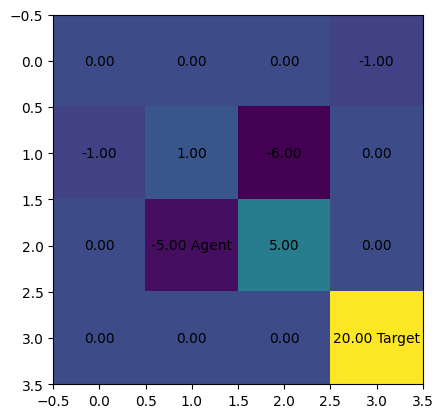

Step 4 Reward 5
Current time: 4


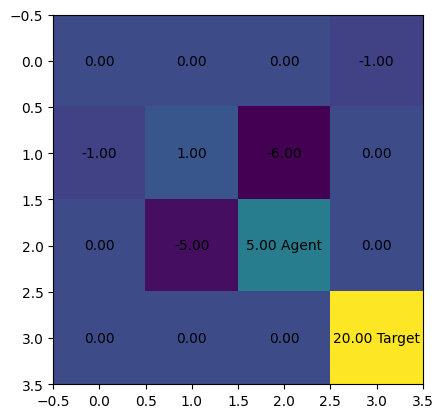

Step 5 Reward 0
Current time: 5


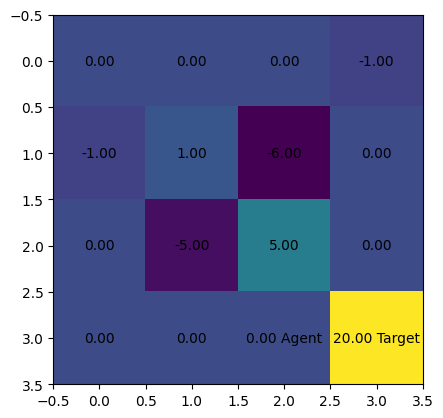

Step 6 Reward 5
Current time: 6


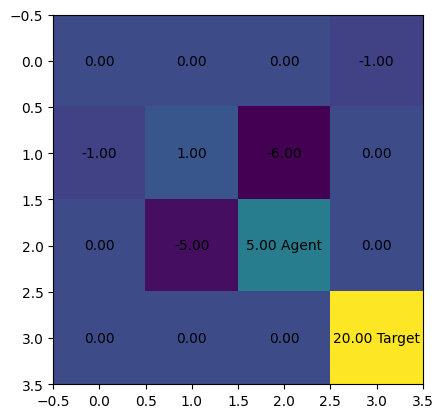

Step 7 Reward 0
Current time: 7


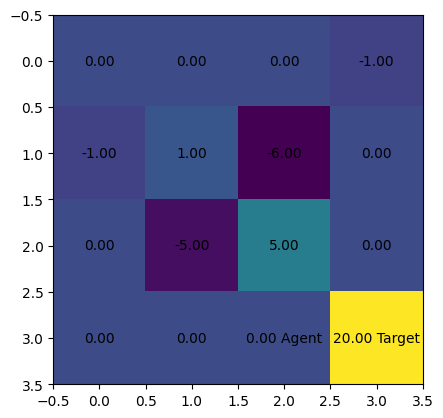

Step 8 Reward 5
Current time: 8


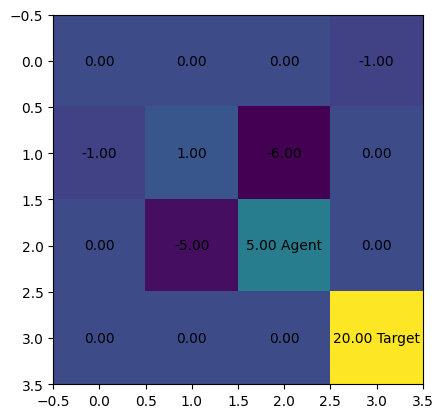

Step 9 Reward 0
Current time: 9


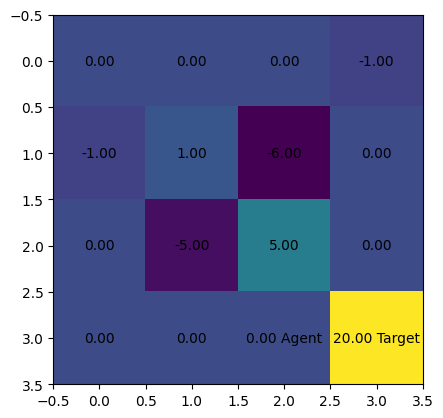

Step 10 Reward 5
Current time: 10


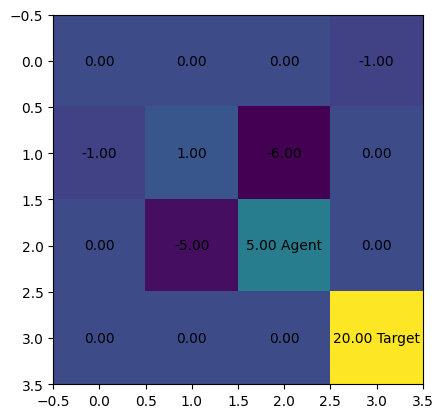

Step 11 Reward 0
Current time: 11


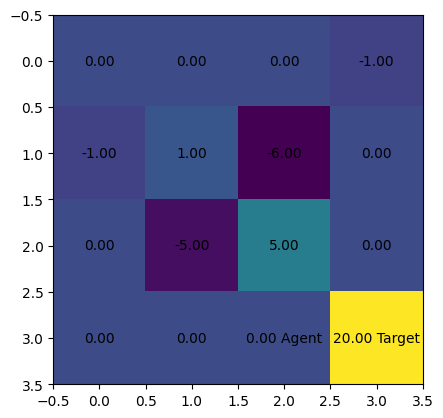

Step 12 Reward 5
Current time: 12


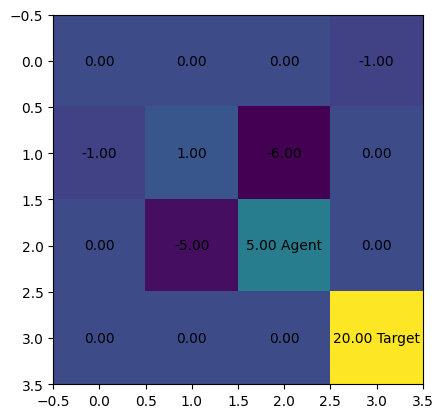

Step 13 Reward 0
Current time: 13


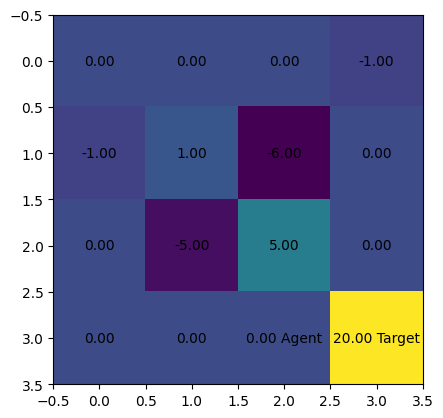

Total reward: 21


In [ ]:
doubleQLR2 = AgentTrial(AgentDoubleQ(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.75, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQLR2.train()

doubleQLR2.greedy_eval()

doubleQLR2.print_q_tables()

doubleQLR2.plot()

doubleQLR2.greedy_walk()

Initial Q1-Table
[[0.91382357 0.64817942 0.8908878  0.7927905 ]
 [0.68407626 0.59484424 0.62036541 0.02789823]
 [0.34084456 0.55609257 0.67807375 0.05617532]
 [0.8213818  0.66268807 0.09727798 0.2758327 ]
 [0.3068752  0.02109727 0.09830921 0.85037728]
 [0.6304281  0.46712815 0.09741271 0.81321533]
 [0.79784824 0.34101435 0.41833437 0.86319723]
 [0.1577546  0.72127471 0.89051265 0.59421958]
 [0.13492413 0.47388265 0.87417916 0.48132462]
 [0.33565229 0.68298725 0.32856496 0.2930132 ]
 [0.94350172 0.29330273 0.20818659 0.60730893]
 [0.16202686 0.7096629  0.34584672 0.01640226]
 [0.38980829 0.73004401 0.65363972 0.81224058]
 [0.36843641 0.578096   0.18101722 0.77936387]
 [0.00907631 0.23423996 0.89093506 0.81008457]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.31876451 0.67734503 0.17776508 0.1310553 ]
 [0.50223729 0.86818329 0.15874365 0.00686762]
 [0.54111975 0.91094291 0.36202955 0.5164345 ]
 [0.79621648 0.33233809 0.52897381 0.60586145]
 [0.9807615  0.52382726 0

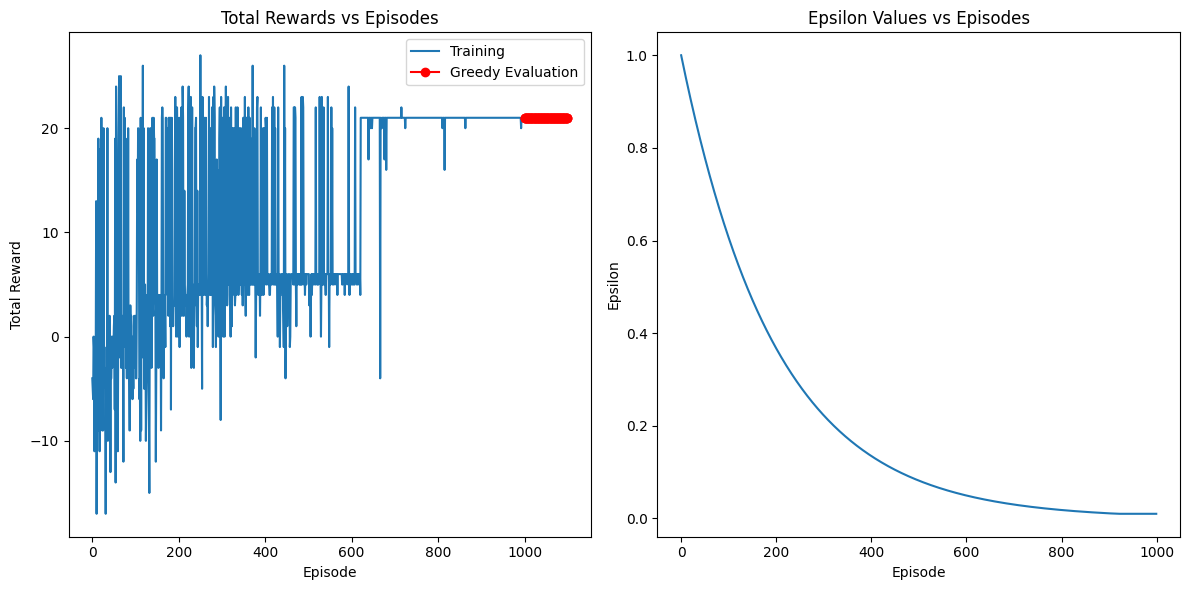

Current time: 0


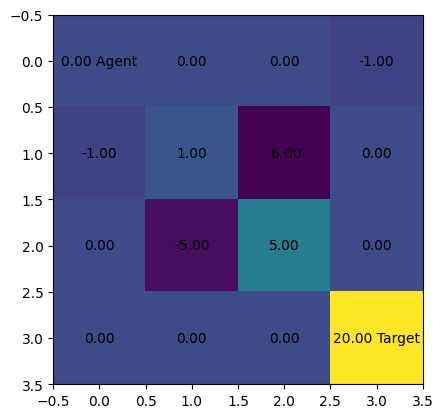

Step 1 Reward 0
Current time: 1


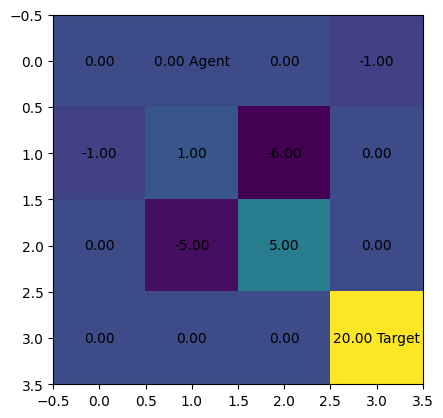

Step 2 Reward 1
Current time: 2


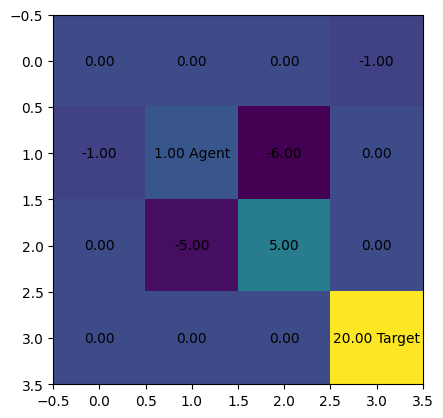

Step 3 Reward -5
Current time: 3


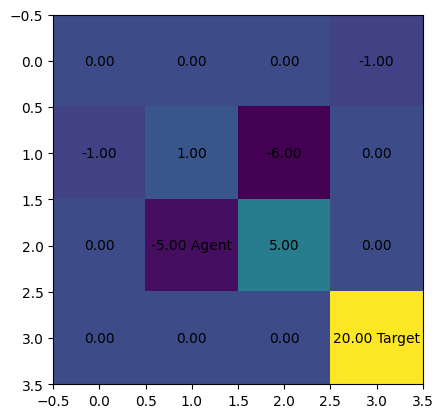

Step 4 Reward 5
Current time: 4


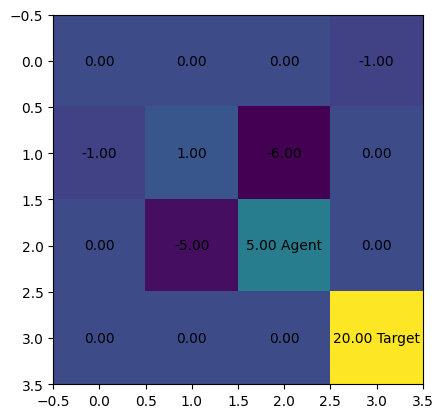

Step 5 Reward 0
Current time: 5


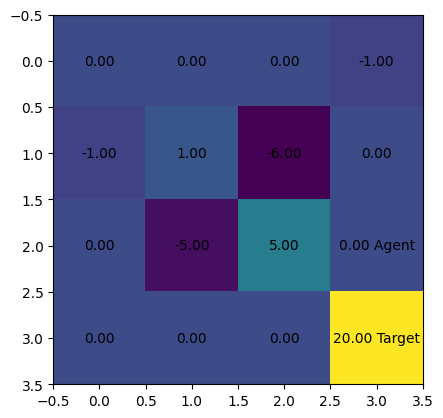

Step 6 Reward 20
Current time: 6


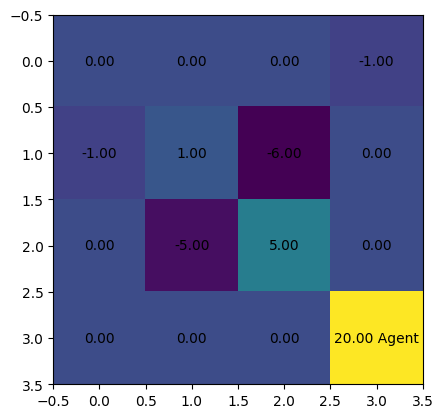

Total reward: 21


In [ ]:
doubleQLR3 = AgentTrial(AgentDoubleQ(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.05, epsilon = 1.0, epsilon_min = 0.01), 'DoubleQ')

doubleQLR3.train()

doubleQLR3.greedy_eval()

doubleQLR3.print_q_tables()

doubleQLR3.plot()

doubleQLR3.greedy_walk()

## Double Q Learning with Optuna hyperparameter search on Discount Factor and Learning Rate hyperparameter

In [ ]:
def objective_double_q(trial):
    discount_factor = trial.suggest_float("discount_factor", 0.5, 0.99, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)

    double_q_agent = AgentDoubleQ(
        discount_factor=discount_factor,
        learning_rate=learning_rate
    )

    train_episodes = 1000
    total_rewards, _ = double_q_agent.train(num_episodes=train_episodes)

    return np.mean(total_rewards)

In [ ]:
study_double_q = optuna.create_study(direction="maximize")
study_double_q.optimize(objective_double_q, n_trials=200)

[I 2023-12-07 20:09:24,051] A new study created in memory with name: no-name-33f2cee2-0d6c-423b-a565-7503966e5151
[I 2023-12-07 20:09:24,250] Trial 0 finished with value: 17.233 and parameters: {'discount_factor': 0.9407057079563362, 'learning_rate': 0.13744001719884105}. Best is trial 0 with value: 17.233.
[I 2023-12-07 20:09:24,516] Trial 1 finished with value: 17.425 and parameters: {'discount_factor': 0.6736995593017795, 'learning_rate': 0.33270946110945115}. Best is trial 1 with value: 17.425.
[I 2023-12-07 20:09:24,921] Trial 2 finished with value: 6.459 and parameters: {'discount_factor': 0.5806811012567348, 'learning_rate': 0.031782440853126245}. Best is trial 1 with value: 17.425.
[I 2023-12-07 20:09:25,145] Trial 3 finished with value: 15.235 and parameters: {'discount_factor': 0.6578963914068513, 'learning_rate': 0.08604191956987084}. Best is trial 1 with value: 17.425.
[I 2023-12-07 20:09:25,554] Trial 4 finished with value: 6.154 and parameters: {'discount_factor': 0.86447

Best Hyperparameters:
{'discount_factor': 0.7214673853197576, 'learning_rate': 0.4604669545898346}
Initial Q1-Table
[[0.40105478 0.07685818 0.0535453  0.85671837]
 [0.25162304 0.92461476 0.96641219 0.80075118]
 [0.24309727 0.93499472 0.77791458 0.90476026]
 [0.08407041 0.69939744 0.06993844 0.96545143]
 [0.5972039  0.28193442 0.74683663 0.44460059]
 [0.6313126  0.31445489 0.27260385 0.16874133]
 [0.34413499 0.47481877 0.20080461 0.02594286]
 [0.18338137 0.96130191 0.96417841 0.17301952]
 [0.70154643 0.86407112 0.32317693 0.1435834 ]
 [0.43809909 0.01125431 0.20872316 0.90154375]
 [0.90521733 0.46255916 0.28847105 0.74287576]
 [0.95063569 0.95988602 0.5920287  0.34314455]
 [0.90063307 0.36005525 0.70148235 0.7896764 ]
 [0.96239925 0.90996591 0.1805095  0.92332807]
 [0.04433256 0.14151204 0.76284538 0.43226809]
 [0.         0.         0.         0.        ]]
Initial Q2-Table
[[0.60762112 0.03482548 0.19693892 0.52757345]
 [0.42571042 0.74236672 0.26046882 0.54253293]
 [0.08805259 0.75571

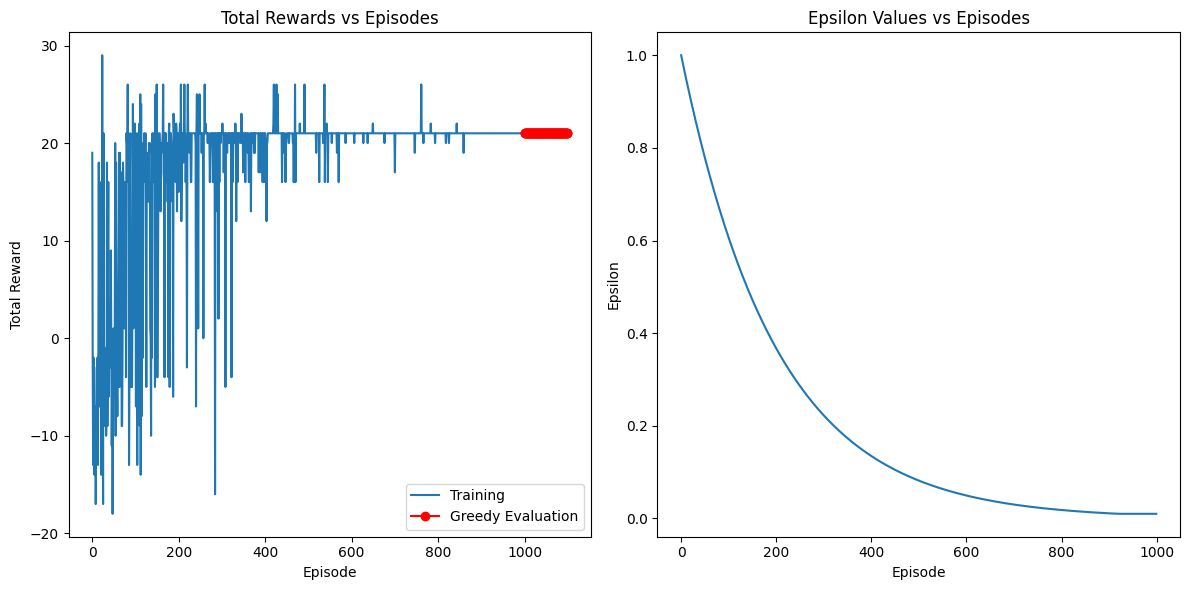

Current time: 0


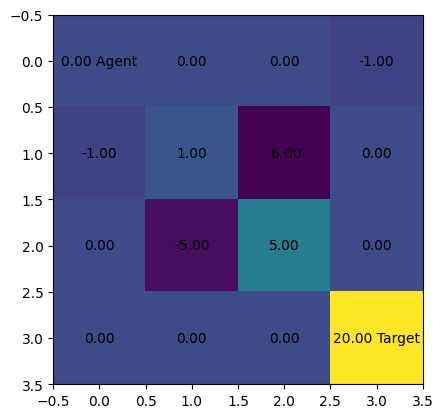

Step 1 Reward 0
Current time: 1


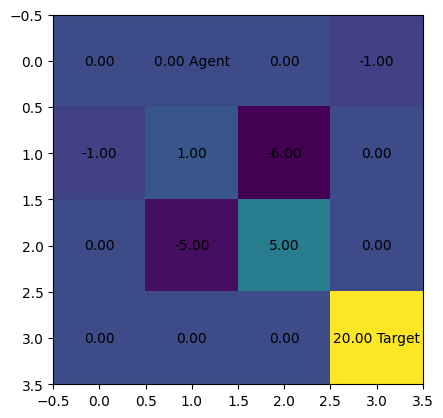

Step 2 Reward 1
Current time: 2


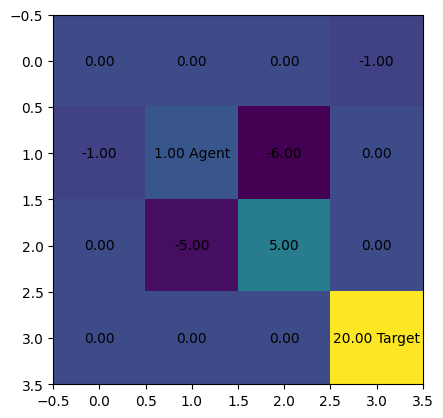

Step 3 Reward -5
Current time: 3


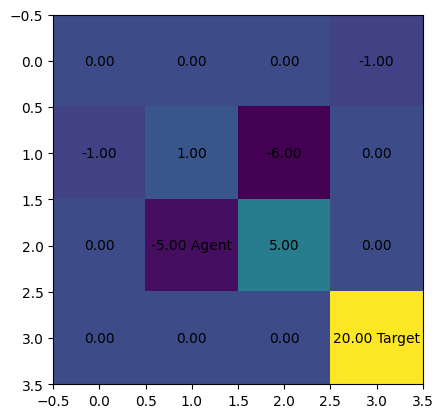

Step 4 Reward 5
Current time: 4


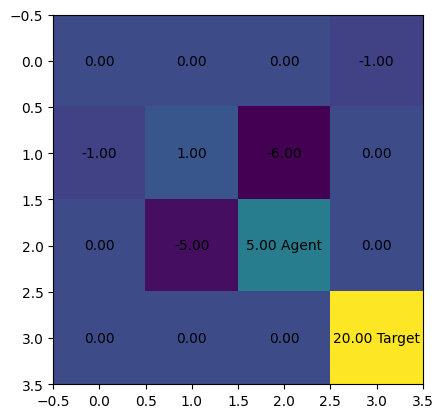

Step 5 Reward 0
Current time: 5


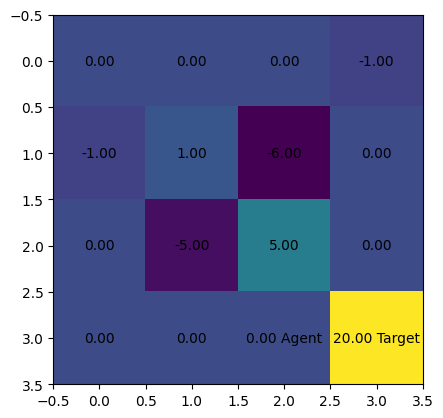

Step 6 Reward 20
Current time: 6


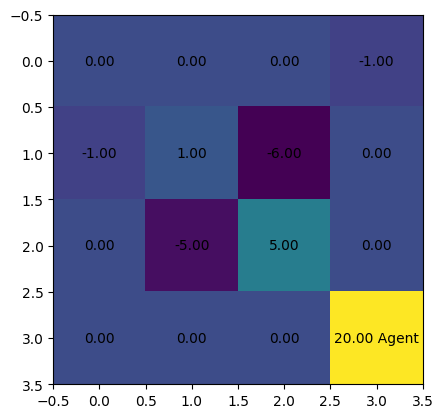

Total reward: 21


In [ ]:
# Get the best hyperparameters
best_double_q_params = study_double_q.best_params
print("Best Hyperparameters:")
print(best_double_q_params)

doubleQBest = AgentTrial(AgentDoubleQ(**best_double_q_params), 'DoubleQ')

doubleQBest.train()

doubleQBest.greedy_eval()

doubleQBest.print_q_tables()

doubleQBest.plot()

doubleQBest.greedy_walk()

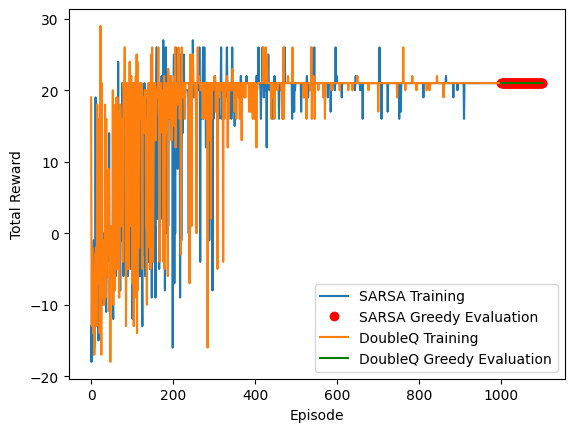

In [ ]:
# Plot total reward per episode for both SARSA and Double Q
plt.plot(sarsaBest.total_rewards, label='SARSA Training')
plt.plot(range(sarsaBest.train_episodes, sarsaBest.train_episodes+sarsaBest.greedy_episodes), sarsaBest.greedy_rewards, 'ro', label='SARSA Greedy Evaluation')
plt.plot(doubleQBest.total_rewards, label='DoubleQ Training')
plt.plot(range(doubleQBest.train_episodes, doubleQBest.train_episodes+doubleQBest.greedy_episodes), doubleQBest.greedy_rewards, 'g-', label='DoubleQ Greedy Evaluation')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

## N Step SARSA Learning

In [ ]:
class AgentNStepSARSA(GridWorldEnv):
    def __init__(self, discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01, n = 2):
        super().__init__()
        # Q-table initialization
        self.Q_table = np.random.rand(len(self.states), len(self.actions))
        self.Q_table[self.state_space_flat[self.states.index(self.target_state)]] = np.zeros(len(self.actions))

        # SARSA-specific parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.n_steps = n

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Exploration
        else:
            flat_state = self.flatten_state(state)
            return np.argmax(self.Q_table[flat_state, :])  # Exploitation

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def train(self, num_episodes=1000):
        total_rewards_per_episode = []
        epsilon_values = []

        for episode in range(num_episodes):
            state = self.reset()
            action = self.choose_action(state)
            total_reward = 0
            step_buffer = []
            T = self.max_time
            for t in range(T):  # Using self.max_time as the maximum number of steps in an episode
                next_state, reward, done, _ = self.step(action)
                next_action = self.choose_action(next_state)
                step_buffer.append((state, action, reward))

                total_reward += reward
                state = next_state
                action = next_action

                if done:
                    T = t + 1
                    break

            # Update Q-values using n-step SARSA
            for t in range(len(step_buffer)):
                n = min(self.n_steps, len(step_buffer) - t)
                G = sum([step_buffer[t + i][2] * (self.discount_factor ** i) for i in range(n)])
                if t + n < len(step_buffer):
                    G += self.discount_factor ** n * self.Q_table[self.flatten_state(step_buffer[t + n][0]), step_buffer[t + n][1]]
                current_value = self.Q_table[self.flatten_state(step_buffer[t][0]), step_buffer[t][1]]
                updated_value = current_value + self.learning_rate * (G - current_value)
                self.Q_table[self.flatten_state(step_buffer[t][0]), step_buffer[t][1]] = updated_value

            total_rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.decay_epsilon()

        return total_rewards_per_episode, epsilon_values

    def evaluate_greedy_policy(self, num_episodes=10):
        total_rewards_per_episode = []

        for episode in range(num_episodes):
            state = self.reset()
            total_reward = 0
            while True:
                action = np.argmax(self.Q_table[self.flatten_state(state), :])  # Greedy action
                next_state, reward, done, _ = self.step(action)

                total_reward += reward
                state = next_state

                if done:
                    break

            total_rewards_per_episode.append(total_reward)

        return total_rewards_per_episode

    def visualize_greedy_policy(self, renderMode = 'Array'):
        state = self.reset()
        total_reward = 0
        self.render(renderMode)
        while True:
            action = np.argmax(self.Q_table[self.flatten_state(state), :])  # Greedy action
            next_state, reward, done, _ = self.step(action)

            total_reward += reward
            state = next_state
            print(f"Step {self.current_time} Reward {reward}")
            self.render(renderMode)
            if done:
                break
        print(f"Total reward: {total_reward}")

Initial Q-Table
[[0.40604236 0.94557209 0.80510468 0.90281072]
 [0.77537027 0.27710136 0.38035125 0.49764674]
 [0.16332209 0.8206975  0.9688099  0.4550612 ]
 [0.562946   0.08251536 0.85993693 0.34702288]
 [0.32058791 0.17706431 0.47698746 0.96784401]
 [0.1111059  0.45954793 0.91818996 0.82280688]
 [0.54639566 0.52304214 0.32182997 0.98564858]
 [0.30298559 0.13693519 0.42717591 0.32361211]
 [0.16811277 0.46859697 0.51033249 0.75219095]
 [0.44729307 0.22228754 0.32018751 0.2306233 ]
 [0.34970717 0.99635337 0.12287602 0.28994421]
 [0.26757508 0.7766428  0.90512621 0.57875706]
 [0.5381568  0.24267948 0.67402575 0.67125228]
 [0.93343041 0.36685369 0.82674092 0.32987937]
 [0.10732129 0.07113196 0.61357047 0.39576618]
 [0.         0.         0.         0.        ]]

Final Q-Table
[[ 7.37219245 11.30352962  9.870394    8.31921079]
 [ 2.81167213 13.1979448   1.94621877  2.71117624]
 [-0.43480787  0.92926263 -1.51902936  4.73503777]
 [ 0.76245761  3.66741676  1.10599576 -0.88503504]
 [ 7.1617999

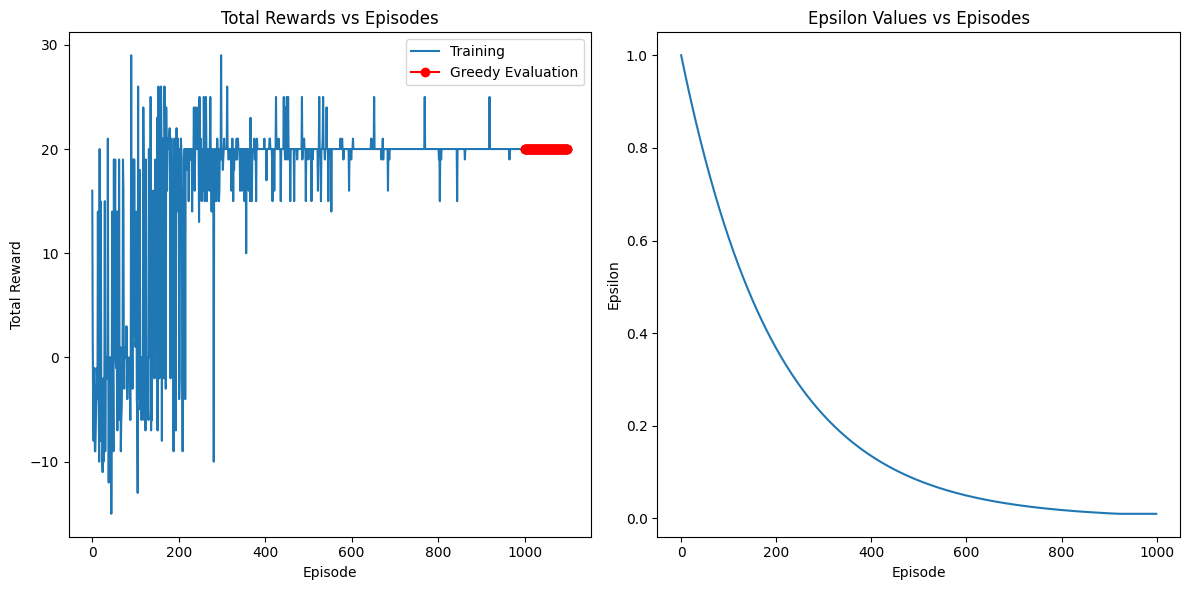

Current time: 0


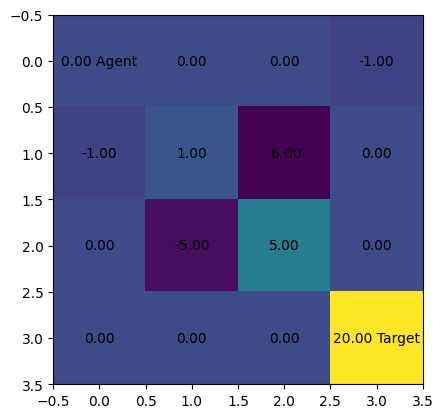

Step 1 Reward -1
Current time: 1


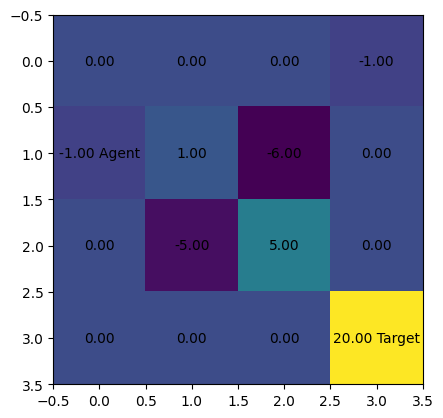

Step 2 Reward 1
Current time: 2


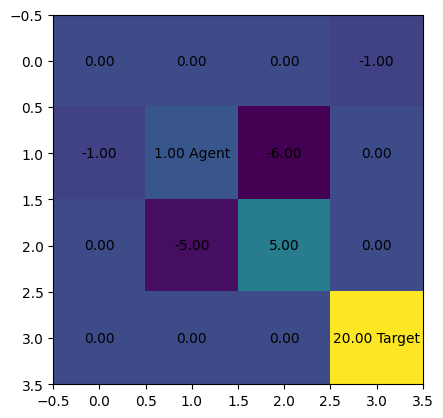

Step 3 Reward -5
Current time: 3


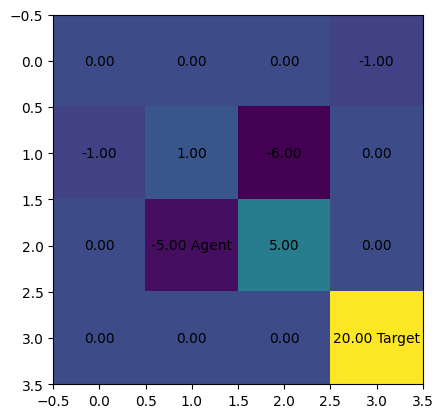

Step 4 Reward 5
Current time: 4


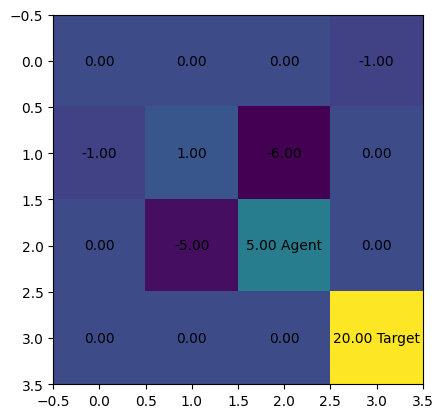

Step 5 Reward 0
Current time: 5


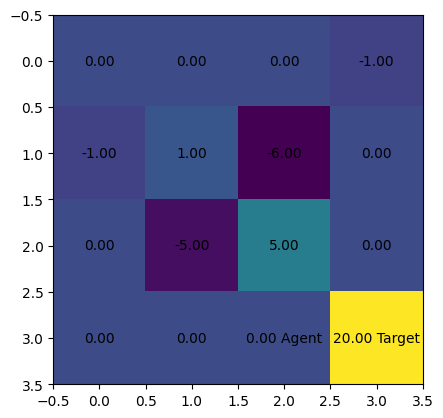

Step 6 Reward 20
Current time: 6


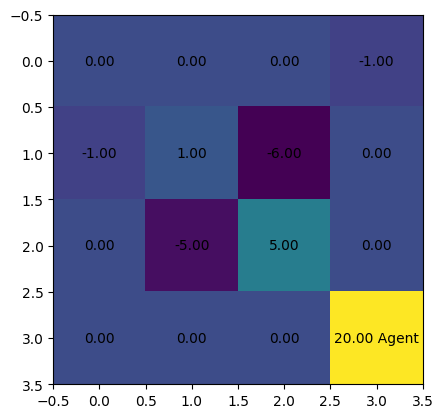

Total reward: 20


In [ ]:
sarsaNStepBase = AgentTrial(AgentNStepSARSA(discount_factor = 0.9, epsilon_decay = 0.995, learning_rate = 0.15, epsilon = 1.0, epsilon_min = 0.01, n = 3), 'SARSA')

sarsaNStepBase.train()

sarsaNStepBase.greedy_eval()

sarsaNStepBase.print_q_tables()

sarsaNStepBase.plot()

sarsaNStepBase.greedy_walk()

#### References
1) https://docs.python.org/3/index.html

2) https://matplotlib.org/stable/

3) https://numpy.org/doc/stable/index.html

4) https://gymnasium.farama.org/

5) https://optuna.readthedocs.io/en/stable/